![logo](https://climate.copernicus.eu/sites/default/files/2025-03/logoline_c3s.png)

# Analyzing Ocean Colour and Sea Surface Temperature during El Niño and La Niña Events

**This notebook can be run on free online platforms, such as Binder, Kaggle and Colab, or they can be accessed from GitHub. The links to run this notebook in these environments are provided here, but please note they are not supported by ECMWF.**

[![binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/ecmwf-training/c3s-training-submodule-sat-obs-ocean/develop?labpath=ocean-colour-sea-surface-temperature.ipynb)
[![kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)
[![colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)
[![github](https://img.shields.io/badge/Open%20in-GitHub-black?logo=github)](https://github.com/ecmwf-training/c3s-training-submodule-sat-obs-ocean/blob/develop/ocean-colour-sea-surface-temperature.ipynb)

## Learning objectives 🎯

This tutorial provides a practical introduction to daily **Ocean Colour (OC)** data (available from 1997 onwards) and **Sea Surface Temperature (SST)** data (available from 1981 to 2016), both derived from satellite observations of the global ocean.

These datasets are freely accessible from the Climate Data Store (CDS) with a registered account.

In this example, we will use the variable `mass chlorophyll-a per unit volume of near-surface water` (mg m⁻³) from the OC dataset and the `Analysed SST` (K) from the SST dataset to compare **December values** during an **El Niño (2015)** year, a **La Niña (1999)** year, and a **neutral (2013)** year in the equatorial Pacific.

**Sea Surface Temperature** and **Chlorophyll-a concentration** are key indicators of oceanic conditions and are closely associated with El Niño and La Niña events. The gridded datasets from CDS support the examination of oceanic changes on different spatial scales on a daily basis and are available globally for both OC and SST.

In this tutorial notebook, we provide step-by-step instructions on:
1. Learn how to **subset and download** OC and SST datasets from CDS for December 1999, 2013 and 2015.
2. Examine the daily datasets downloaded
3. Extract daily `chl_a` and `analysed_SST` data to visualise **daily time series** for each variable comparing of all three years.
4. Aggregate the daily data to **monthly** NetCDF files.
5. Visualise monthly averaged values as maps to examine spatial change in distribution of `chl_a` and `analysed_SST`.
6. Calculate **anomalies** in December during El Niña and La Niña years compared to a "neutral" year and plot them in maps.<br>

## Prepare your environment

This chapter provides information on how to run the notebook, the required Python libraries, and how to import them. It also guides you through the process of downloading the data via the CDSAPI.

### Set up CDSAPI and your credentials

The code below will ensure that the `cdsapi` package is installed. If you have not setup your `~/.cdsapirc` file with your credenials, you can replace `None` with your credentials that can be found on the [how to api](https://cds.climate.copernicus.eu/how-to-api) page (you will need to log in to see your credentials).

In [2]:
!pip install -q cdsapi
# If you have already setup your .cdsapirc file you can leave this as None
cdsapi_key = None
cdsapi_url = None

### (Install and) Import libraries

This tutorial is written in **Python** and requires basic Python knowledge and an environment that includes the following Python libraries:

| Library   | Purpose |
|-----------|---------|
| **[cdsapi](https://pypi.org/project/cdsapi/)**  | Access and download data from the Copernicus Climate Data Store |
| **[os](https://docs.python.org/3/library/os.html)**  | Handle file and directory operations |
| **[zipfile](https://docs.python.org/3/library/zipfile.html)**  | Extract and manage ZIP archive files |
| **[xarray](https://xarray.dev/)**  | Work with multi-dimensional labeled datasets, commonly used for NetCDF files (format of OC and SST data from CDS) |
| **[netCDF4](https://unidata.github.io/netcdf4-python/)** | Read and write NetCDF files directly |
| **[dask](https://www.dask.org/)** | Enable parallel computing and efficient handling of large datasets with xarray |
| **[glob](https://docs.python.org/3/library/glob.html)**  | Search for file paths using pattern matching |
| **[cartopy](https://scitools.org.uk/cartopy/docs/latest/)**  | Create maps and visualize geospatial data |
| **[matplotlib](https://matplotlib.org/stable/index.html)**  | Generate plots, charts, and visualizations |

In [3]:
import cdsapi
import os
import zipfile

import xarray as xr
import netCDF4
import dask
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import FuncFormatter

#### Define subset area and years

In this tutorial, we will exploratively analyze two specific events (El Niño and La Niña) in an area of interest (the equatorial Pacific) and compare the results to a 'neutral' year to understand their impact on oceanic conditions. <br>

To do this, we will define the `years` and `area` for data download here:

In [4]:
# Define the years
# Here: 1999 La Nina; 2013 Neutral; 2015 El Nino
years = [1999, 2013, 2015]

# Define the region of interest
# Here: Pacific Ocean near South America to observe El Nino and La Nina events
# area = [North, West, South, East]
area = [20, -160, -20, -80]

## Explore data

This notebook uses two Essential Climate Variable (ECV) datasets derived from satellite observations from the **Copernicus Climate Data Store**:

1. **Ocean Colour (Chlorophyll-a concentration)**
   - **Variable**: `mass chlorophyll-a per unit volume of near-surface water`
   - **Temporal coverage**: Daily
   - **Units**: mg/m³ - Mass chlorophyll-a per unit of volume of near-surface water.
   - **Definition**: Chlorophyll-a (Chl-a) is the main photosynthetic pigment found in phytoplankton, which form the base of the marine food-web and are responsible for approximately half of global photosynthesis.
   - **ECV importance**: Ocean colour plays an essential role in our ability to monitor the health and productivity of marine ecosystems, assess the role of the oceans in the global carbon cycle, and quantify the impacts of climate change. 

2. **Sea Surface Temperature (SST)**
   - **Variable**: `Analysed SST`
   - **Temporal coverage**: Daily
   - **Units**: Kelvin (K) - Median of the 16 input SST analyses (one field).
   - **Definition**: SST represents the temperature of the ocean’s surface layer and is a fundamental parameter in climate and weather prediction.
   - **ECV importance**: SST influences air–sea interactions, weather patterns, ocean circulation, and marine ecosystems. It is a core parameter for climate monitoring.

**These two ECVs are closely linked**: sea surface temperature affects biological processes such as phytoplankton growth, while ocean colour (via chlorophyll-a) provides insight into those biological responses to changing physical conditions. Together, they provide a valuable picture of the ocean's role in the Earth system.

For detailed information on the datasets, please visit the CDS website:
__[Daily Ocean Colour](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=overview")__ & __[Daily Sea Surface Temperature](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=overview)__

### Download the data

There is a limit to how much data can be downloaded from the CDS at once. Since the OC and SST datasets are large, we will quickly reach this limit. You can check the limit manually by using the "Download" option on the dataset websites (right panel: "Request Validation": __[OC](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=download)__ & __[SST](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=download)__).  

To avoid downloading each dataset separately, we will automate the process by looping through each day, downloading and unzipping the data, and storing it locally.

The `OC` and `SST` data will be downloaded in a daily zip files containing a NetCDF file for each variable by default. We want to dowload the data, **unzip the daily NetCDF files** and **store them directly into monthly folders** for every year. 

Resulting in the following folder structure: 
- `data_cds_oc` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)
- `data_cds_sst` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)

<div class="alert alert-block alert-warning">
<b>Important Note:</b>  It will take approx. <b>30 mins to download OC data</b> and <b>30 mins to download SST data</b> for this tutorial's subset area and temporal selection of daily data for December 1999, 2013, and 2015. 

Please be aware that when selecting larger timeframes or areas, the download time could take even longer and could result in file sizes ≥ 1 GB.
</div>

##### Download Daily Ocean Colour data

Now we are ready to request the data via the CDS API and donwload the daily OC data for December of 1999, 2013 an 2015.

The request is defined by the following key variables:
- Product: `satellite-ocean-colour`
- Variable: `mass_concentration_of_chlorophyll_a` in mg m-3
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`
- Version: `6_0` for the most up to date version

In [5]:
# Create the base directory for data storage
base_dir = "data_cds_oc"
os.makedirs(base_dir, exist_ok=True)

# Initialize the CDS API client
client = cdsapi.Client()

# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(base_dir, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)

    # Loop through each day in December (1 to 31)
    for day in range(1, 32):
        day_str = f"{day:02d}"

        # Request data for the current day
        request = {
            "variable": ["mass_concentration_of_chlorophyll_a"],
            "projection": "regular_latitude_longitude_grid",
            "year": [str(year)],
            "month": ["12"],
            "day": [day_str],
            "area": area,
            "version": "6_0"
        }

        # Download data for the current day and store it in the corresponding folder
        print(f"Downloading data for {year}-12-{day_str}...")
        download_path = os.path.join(
            year_month_folder, f"{year}_12_{day_str}.nc.zip"
        )
        client.retrieve(
            "satellite-ocean-colour",
            request,
            download_path,
            )

        # Unzip the downloaded file
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(year_month_folder)

        # Delete the original zip file after extraction
        os.remove(download_path)

        print(f"Data for {year}-12-{day_str} successfully downloaded and unzipped!")

print("All downloads are complete!")

2025-09-12 11:16:25,711 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-09-12 11:16:25,953 INFO Request ID is 9f533b62-e4db-4f05-92c1-80620d8c67c4
2025-09-12 11:16:26,051 INFO status has been updated to accepted
2025-09-12 11:16:39,877 INFO status has been updated to running
2025-09-12 11:16:47,595 INFO status has been updated to successful


75972067142df079035c852df785abc4.zip:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

Data for 1999-12-01 successfully downloaded and unzipped!


2025-09-12 11:16:48,927 INFO Request ID is c79f84d6-c6d1-4254-9c12-86213cda0797
2025-09-12 11:16:49,078 INFO status has been updated to accepted
2025-09-12 11:17:02,932 INFO status has been updated to running
2025-09-12 11:17:10,617 INFO status has been updated to successful


662d5aa5c4bf13e0746982cdd4737a1a.zip:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

Data for 1999-12-02 successfully downloaded and unzipped!


2025-09-12 11:17:12,673 INFO Request ID is 7e332665-72ae-4490-9463-d39ca35dbbac
2025-09-12 11:17:12,739 INFO status has been updated to accepted
2025-09-12 11:17:21,744 INFO status has been updated to running
2025-09-12 11:17:34,676 INFO status has been updated to successful


442f2dcf68c535459f53b85b099b6341.zip:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

Data for 1999-12-03 successfully downloaded and unzipped!


2025-09-12 11:17:36,094 INFO Request ID is 22f3d382-5f87-4efa-a57b-c46e6326b35e
2025-09-12 11:17:36,177 INFO status has been updated to accepted
2025-09-12 11:17:50,226 INFO status has been updated to running
2025-09-12 11:18:09,382 INFO status has been updated to successful


bd676d4fc73d80e33230dbcc85c89975.zip:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

Data for 1999-12-04 successfully downloaded and unzipped!


2025-09-12 11:18:11,004 INFO Request ID is b6733e11-5eaa-4494-b610-402792e9ae95
2025-09-12 11:18:11,414 INFO status has been updated to accepted
2025-09-12 11:18:25,056 INFO status has been updated to running
2025-09-12 11:18:32,796 INFO status has been updated to successful


fb5a5aa58b51b511e1604872dbf0937b.zip:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Data for 1999-12-05 successfully downloaded and unzipped!


2025-09-12 11:18:34,378 INFO Request ID is ffcf7040-4bb6-46b6-af96-c8dd86d74c75
2025-09-12 11:18:34,444 INFO status has been updated to accepted
2025-09-12 11:18:48,056 INFO status has been updated to running
2025-09-12 11:19:07,237 INFO status has been updated to successful


eca87cbbe3010e9730c27a45dbad1115.zip:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

Data for 1999-12-06 successfully downloaded and unzipped!


2025-09-12 11:19:08,774 INFO Request ID is 5ef66e23-cf0a-44e3-b284-52ff48dd0e8f
2025-09-12 11:19:08,911 INFO status has been updated to accepted
2025-09-12 11:19:22,756 INFO status has been updated to running
2025-09-12 11:19:30,446 INFO status has been updated to successful


16959a821deba6550841df808bdcb397.zip:   0%|          | 0.00/2.47M [00:00<?, ?B/s]

Data for 1999-12-07 successfully downloaded and unzipped!


2025-09-12 11:19:32,032 INFO Request ID is fdcbb954-3e28-4fe1-8a9d-6af85b17b046
2025-09-12 11:19:32,106 INFO status has been updated to accepted
2025-09-12 11:19:40,544 INFO status has been updated to running
2025-09-12 11:19:53,360 INFO status has been updated to successful


9b376d6b3f6e2c780d2047f979ed85f7.zip:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Data for 1999-12-08 successfully downloaded and unzipped!


2025-09-12 11:19:54,671 INFO Request ID is 672e5113-9ac8-4c88-a877-b830141b6b74
2025-09-12 11:19:54,746 INFO status has been updated to accepted
2025-09-12 11:20:08,474 INFO status has been updated to successful


76a73abf5c49da625393626812202dd9.zip:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

Data for 1999-12-09 successfully downloaded and unzipped!


2025-09-12 11:20:09,928 INFO Request ID is 61f6a56d-7658-4846-92bd-69096e1c59b1
2025-09-12 11:20:10,026 INFO status has been updated to accepted
2025-09-12 11:20:18,809 INFO status has been updated to running
2025-09-12 11:20:31,667 INFO status has been updated to successful


82f20b5a89dd83861c7c65c2d8b7968a.zip:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Data for 1999-12-10 successfully downloaded and unzipped!


2025-09-12 11:20:33,695 INFO Request ID is 2067f8fe-8840-486f-96ce-fcc469438d86
2025-09-12 11:20:34,937 INFO status has been updated to accepted
2025-09-12 11:21:08,402 INFO status has been updated to successful


cdfa68fe10b153f7d60b00e8c59202c.zip:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

Data for 1999-12-11 successfully downloaded and unzipped!


2025-09-12 11:21:09,686 INFO Request ID is ebe7f571-f6ef-466e-a820-4d44fd6a28d1
2025-09-12 11:21:09,851 INFO status has been updated to accepted
2025-09-12 11:21:18,436 INFO status has been updated to running
2025-09-12 11:21:31,248 INFO status has been updated to successful


7e368aa21564f2e6ba242a9748e0c2d2.zip:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

Data for 1999-12-12 successfully downloaded and unzipped!


2025-09-12 11:21:33,259 INFO Request ID is a5b5e7c6-24b6-49ff-9d05-348bbff65ad3
2025-09-12 11:21:35,359 INFO status has been updated to accepted
2025-09-12 11:21:48,931 INFO status has been updated to successful


603b4d95884f53fb6cb9d4c4e02cf461.zip:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

2025-09-12 11:21:50,698 INFO Request ID is 1a53cc12-145b-487b-9fe3-6126b632eddf


Data for 1999-12-13 successfully downloaded and unzipped!


2025-09-12 11:21:50,765 INFO status has been updated to accepted
2025-09-12 11:21:59,222 INFO status has been updated to running
2025-09-12 11:22:12,061 INFO status has been updated to successful


a18d14756fa95ff72189830af9c1dea1.zip:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

Data for 1999-12-14 successfully downloaded and unzipped!


2025-09-12 11:22:13,735 INFO Request ID is d36a16ec-6a6f-4475-bc20-2dce3a429848
2025-09-12 11:22:13,802 INFO status has been updated to accepted
2025-09-12 11:22:27,426 INFO status has been updated to successful


b48bf0c7c43bf58bb81b98e24cbb002b.zip:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

Data for 1999-12-15 successfully downloaded and unzipped!


2025-09-12 11:22:29,055 INFO Request ID is 2e8d60f8-d922-4a59-b712-fa1a4cfef6b8
2025-09-12 11:22:29,144 INFO status has been updated to accepted
2025-09-12 11:22:38,293 INFO status has been updated to running
2025-09-12 11:22:43,467 INFO status has been updated to successful


d844512ea50f36a3057637244907c770.zip:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Data for 1999-12-16 successfully downloaded and unzipped!


2025-09-12 11:22:45,027 INFO Request ID is 01c29faf-30fd-42fb-bc59-f72747f2f688
2025-09-12 11:22:45,113 INFO status has been updated to accepted
2025-09-12 11:22:58,739 INFO status has been updated to running
2025-09-12 11:23:06,435 INFO status has been updated to successful


6a84cdccb82c8c7526af9b6eb666b89e.zip:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

Data for 1999-12-17 successfully downloaded and unzipped!


2025-09-12 11:23:08,008 INFO Request ID is 5a1fe4dc-4e3e-423d-84c1-2088f8ff01b7
2025-09-12 11:23:08,295 INFO status has been updated to accepted
2025-09-12 11:23:16,916 INFO status has been updated to running
2025-09-12 11:23:22,094 INFO status has been updated to successful


6a7cf06e074796e7f3fc6d2aa19a1483.zip:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

Data for 1999-12-18 successfully downloaded and unzipped!


2025-09-12 11:23:23,516 INFO Request ID is f9bdfd11-2f4f-462c-ac1e-8e32ae8f7bdf
2025-09-12 11:23:23,608 INFO status has been updated to accepted
2025-09-12 11:23:32,067 INFO status has been updated to running
2025-09-12 11:23:44,872 INFO status has been updated to successful


394b925bd2e5b746093426dfd212f9e6.zip:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Data for 1999-12-19 successfully downloaded and unzipped!


2025-09-12 11:23:46,318 INFO Request ID is 960c8c14-1ce1-4d9d-b0a7-c718336b1a72
2025-09-12 11:23:46,411 INFO status has been updated to accepted
2025-09-12 11:24:08,303 INFO status has been updated to successful


3d5092a46db00366da2c63a91cb270f2.zip:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

2025-09-12 11:24:09,843 INFO Request ID is d425f104-58ea-4c17-a66f-93f353730de0


Data for 1999-12-20 successfully downloaded and unzipped!


2025-09-12 11:24:09,910 INFO status has been updated to accepted
2025-09-12 11:24:23,615 INFO status has been updated to running
2025-09-12 11:24:31,278 INFO status has been updated to successful


4dba7ba6a30fb6ae0efc6c18a8f44b4b.zip:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

Data for 1999-12-21 successfully downloaded and unzipped!


2025-09-12 11:24:34,254 INFO Request ID is 212e3780-b29f-47d0-89b0-40abee7ad056
2025-09-12 11:24:34,354 INFO status has been updated to accepted
2025-09-12 11:24:42,977 INFO status has been updated to running
2025-09-12 11:24:56,065 INFO status has been updated to successful


7bf409010fb75a307a0728e2e0b3b389.zip:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

Data for 1999-12-22 successfully downloaded and unzipped!


2025-09-12 11:24:57,654 INFO Request ID is 9ac0a48e-de4a-46c1-b99b-9404b073d32f
2025-09-12 11:24:57,748 INFO status has been updated to accepted
2025-09-12 11:25:30,548 INFO status has been updated to successful


3359dff0cadeab4bf3356ddae7cd53c5.zip:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

2025-09-12 11:25:32,001 INFO Request ID is 9e512e4b-650c-4eb4-9d19-c7d84ae2eecb


Data for 1999-12-23 successfully downloaded and unzipped!


2025-09-12 11:25:32,080 INFO status has been updated to accepted
2025-09-12 11:25:45,712 INFO status has been updated to running
2025-09-12 11:26:04,879 INFO status has been updated to successful


9d77b07b14e126e2a39ab5245c6291cf.zip:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

Data for 1999-12-24 successfully downloaded and unzipped!


2025-09-12 11:26:06,381 INFO Request ID is 7b514913-82d0-48bb-9c8b-84a11a30f537
2025-09-12 11:26:06,604 INFO status has been updated to accepted
2025-09-12 11:26:20,383 INFO status has been updated to running
2025-09-12 11:26:28,155 INFO status has been updated to accepted
2025-09-12 11:26:39,696 INFO status has been updated to successful


c4ff0f1680691983381c0cafe1717341.zip:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Data for 1999-12-25 successfully downloaded and unzipped!


2025-09-12 11:26:41,459 INFO Request ID is 5b4e477f-9e9e-4395-b401-8dc8c20a18be
2025-09-12 11:26:41,534 INFO status has been updated to accepted
2025-09-12 11:27:03,130 INFO status has been updated to successful


88ae453372335ab0f498e7beefc2149e.zip:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

Data for 1999-12-26 successfully downloaded and unzipped!


2025-09-12 11:27:04,773 INFO Request ID is 16202813-619e-43a9-bdf4-f022fa2926e3
2025-09-12 11:27:04,838 INFO status has been updated to accepted
2025-09-12 11:27:38,250 INFO status has been updated to running
2025-09-12 11:27:55,432 INFO status has been updated to successful


779138f8ab9540fe1a17060374459b9f.zip:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

Data for 1999-12-27 successfully downloaded and unzipped!


2025-09-12 11:27:57,438 INFO Request ID is ebac2966-4bbd-4183-b8ef-3a6c94025159
2025-09-12 11:27:57,554 INFO status has been updated to accepted
2025-09-12 11:28:31,650 INFO status has been updated to successful


79417c341a37daa6727cdd397e03426c.zip:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

Data for 1999-12-28 successfully downloaded and unzipped!


2025-09-12 11:28:33,531 INFO Request ID is d69ec3c2-491e-4580-8eca-9c469788a610
2025-09-12 11:28:33,830 INFO status has been updated to accepted
2025-09-12 11:28:47,814 INFO status has been updated to running
2025-09-12 11:28:55,717 INFO status has been updated to successful


44225b53c5bfa7b62ed997034c61fc4.zip:   0%|          | 0.00/3.08M [00:00<?, ?B/s]

Data for 1999-12-29 successfully downloaded and unzipped!


2025-09-12 11:28:57,283 INFO Request ID is 99abd02e-fe59-4563-93fe-f170458e4ece
2025-09-12 11:28:57,391 INFO status has been updated to accepted
2025-09-12 11:29:05,861 INFO status has been updated to running
2025-09-12 11:29:11,025 INFO status has been updated to successful


849d439a96e36ad5397ee6cd8d0ec25e.zip:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

Data for 1999-12-30 successfully downloaded and unzipped!


2025-09-12 11:29:12,613 INFO Request ID is 0f037cf1-8dc5-4a14-84a4-a4ae47f6eac5
2025-09-12 11:29:12,870 INFO status has been updated to accepted
2025-09-12 11:29:45,817 INFO status has been updated to successful


a4f0708c7f6d7b554534c715c7a06ff6.zip:   0%|          | 0.00/3.28M [00:00<?, ?B/s]

2025-09-12 11:29:47,342 INFO Request ID is 095b2b3a-cdd8-4e29-96dc-6536b229b12f


Data for 1999-12-31 successfully downloaded and unzipped!


2025-09-12 11:29:47,412 INFO status has been updated to accepted
2025-09-12 11:30:01,718 INFO status has been updated to running
2025-09-12 11:30:38,106 INFO status has been updated to successful


241cbb88f1420130a02a74ad5f1bde8.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Data for 2013-12-01 successfully downloaded and unzipped!


2025-09-12 11:30:40,679 INFO Request ID is fc4fa99a-5fd4-417f-83ff-5422db3cb9e6
2025-09-12 11:30:40,828 INFO status has been updated to accepted
2025-09-12 11:30:49,399 INFO status has been updated to running
2025-09-12 11:31:13,862 INFO status has been updated to successful


795d8b0f60fb5958eb38aeb146797963.zip:   0%|          | 0.00/5.76M [00:00<?, ?B/s]

Data for 2013-12-02 successfully downloaded and unzipped!


2025-09-12 11:31:16,354 INFO Request ID is 02a77de9-9658-4f75-988e-ee56ae33e400
2025-09-12 11:31:16,448 INFO status has been updated to accepted
2025-09-12 11:31:24,952 INFO status has been updated to running
2025-09-12 11:31:37,818 INFO status has been updated to successful


9301f459eb6e629454b3ca32c889dc29.zip:   0%|          | 0.00/5.31M [00:00<?, ?B/s]

Data for 2013-12-03 successfully downloaded and unzipped!


2025-09-12 11:31:39,927 INFO Request ID is 30eb1a68-cd8b-4ec6-baff-bbbeb7510fcf
2025-09-12 11:31:40,000 INFO status has been updated to accepted
2025-09-12 11:31:48,624 INFO status has been updated to running
2025-09-12 11:31:53,774 INFO status has been updated to accepted
2025-09-12 11:32:01,453 INFO status has been updated to successful


a7fa0e77e9c3235e3fa148be5a9f7a24.zip:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

Data for 2013-12-04 successfully downloaded and unzipped!


2025-09-12 11:32:03,672 INFO Request ID is b9bfdd06-ba10-4420-b121-9768a5e63b23
2025-09-12 11:32:03,994 INFO status has been updated to accepted
2025-09-12 11:32:12,685 INFO status has been updated to running
2025-09-12 11:32:25,528 INFO status has been updated to successful


1be45fe605892cf9b7613e47e462f28a.zip:   0%|          | 0.00/5.75M [00:00<?, ?B/s]

2025-09-12 11:32:28,411 INFO Request ID is 86f8359b-a238-49c7-b311-758af628063c


Data for 2013-12-05 successfully downloaded and unzipped!


2025-09-12 11:32:28,478 INFO status has been updated to accepted
2025-09-12 11:32:42,089 INFO status has been updated to running
2025-09-12 11:32:49,767 INFO status has been updated to accepted
2025-09-12 11:33:01,401 INFO status has been updated to successful


94822f7446df24f532d16d5cba8e9e53.zip:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

Data for 2013-12-06 successfully downloaded and unzipped!


2025-09-12 11:33:03,779 INFO Request ID is 5b663de3-56eb-4e41-9fff-20705970e466
2025-09-12 11:33:03,914 INFO status has been updated to accepted
2025-09-12 11:33:18,274 INFO status has been updated to running
2025-09-12 11:33:25,966 INFO status has been updated to successful


67db09be001c6e3c6b559473fd863925.zip:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

Data for 2013-12-07 successfully downloaded and unzipped!


2025-09-12 11:33:27,914 INFO Request ID is 9c68dd8b-e416-4244-a904-82cce571df58
2025-09-12 11:33:28,088 INFO status has been updated to accepted
2025-09-12 11:33:42,208 INFO status has been updated to running
2025-09-12 11:33:49,935 INFO status has been updated to successful


fd524a042b4e6a41470783aaa11e7b3c.zip:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

Data for 2013-12-08 successfully downloaded and unzipped!


2025-09-12 11:33:52,806 INFO Request ID is ff083240-9090-4324-9266-5e45429255d7
2025-09-12 11:33:52,944 INFO status has been updated to accepted
2025-09-12 11:34:06,864 INFO status has been updated to running
2025-09-12 11:34:14,586 INFO status has been updated to successful


f18848f9c93c87086c8fb5cabe2ba0c9.zip:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

Data for 2013-12-09 successfully downloaded and unzipped!


2025-09-12 11:34:16,776 INFO Request ID is ff7ce51f-01c6-4ce1-bc56-d9f636cb9b44
2025-09-12 11:34:16,872 INFO status has been updated to accepted
2025-09-12 11:34:25,397 INFO status has been updated to running
2025-09-12 11:34:30,861 INFO status has been updated to successful


c0faf7d46c616abdbfdef83551d7a613.zip:   0%|          | 0.00/4.88M [00:00<?, ?B/s]

Data for 2013-12-10 successfully downloaded and unzipped!


2025-09-12 11:34:32,488 INFO Request ID is 8d4b836e-273d-445b-b757-0634feee7ba9
2025-09-12 11:34:32,652 INFO status has been updated to accepted
2025-09-12 11:34:46,274 INFO status has been updated to running
2025-09-12 11:34:53,942 INFO status has been updated to successful


8d80f4ed7c3376b96961b0ed5ba3166b.zip:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

2025-09-12 11:34:55,461 INFO Request ID is 9bacbe77-7c51-4f22-9650-8fe3428818f1


Data for 2013-12-11 successfully downloaded and unzipped!


2025-09-12 11:34:55,525 INFO status has been updated to accepted
2025-09-12 11:35:09,374 INFO status has been updated to running
2025-09-12 11:35:17,054 INFO status has been updated to successful


3044ed7ae558b588c9ff8d8f93df27b1.zip:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

Data for 2013-12-12 successfully downloaded and unzipped!


2025-09-12 11:35:18,730 INFO Request ID is b680fa3e-cf5c-4b91-bf67-66e6a34cb8bd
2025-09-12 11:35:18,816 INFO status has been updated to accepted
2025-09-12 11:35:32,405 INFO status has been updated to running
2025-09-12 11:35:40,087 INFO status has been updated to successful


43e242a6a4ff3bde192879b0ba06dfa1.zip:   0%|          | 0.00/4.82M [00:00<?, ?B/s]

Data for 2013-12-13 successfully downloaded and unzipped!


2025-09-12 11:35:42,107 INFO Request ID is 40066322-a323-401a-b5fb-7fbd14dfdf3b
2025-09-12 11:35:42,496 INFO status has been updated to accepted
2025-09-12 11:35:56,140 INFO status has been updated to running
2025-09-12 11:36:03,832 INFO status has been updated to successful


be987269e1bd6e7117c8fe58d5d52fe.zip:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

2025-09-12 11:36:06,295 INFO Request ID is 4de2faf0-2634-4094-84eb-825739695516


Data for 2013-12-14 successfully downloaded and unzipped!


2025-09-12 11:36:06,392 INFO status has been updated to accepted
2025-09-12 11:36:14,972 INFO status has been updated to running
2025-09-12 11:36:27,924 INFO status has been updated to successful


3655d002154722ca2e755b4b822bc39b.zip:   0%|          | 0.00/5.57M [00:00<?, ?B/s]

Data for 2013-12-15 successfully downloaded and unzipped!


2025-09-12 11:36:31,606 INFO Request ID is 5d31062e-23c2-4cb1-832e-0ec1ec032277
2025-09-12 11:36:31,698 INFO status has been updated to accepted
2025-09-12 11:36:45,331 INFO status has been updated to running
2025-09-12 11:37:21,740 INFO status has been updated to successful


4c7bbc79e8e26d80bde7fbb7f63a54f1.zip:   0%|          | 0.00/5.77M [00:00<?, ?B/s]

Data for 2013-12-16 successfully downloaded and unzipped!


2025-09-12 11:37:23,875 INFO Request ID is 0571db87-7856-45b8-8166-80c091e3c7ab
2025-09-12 11:37:23,940 INFO status has been updated to accepted
2025-09-12 11:37:37,700 INFO status has been updated to running
2025-09-12 11:38:14,073 INFO status has been updated to successful


ee360c1025a12db18e19da938d40197c.zip:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Data for 2013-12-17 successfully downloaded and unzipped!


2025-09-12 11:38:16,068 INFO Request ID is 784ee8ae-c5cf-4e4a-8c02-5b4af287dfac
2025-09-12 11:38:16,249 INFO status has been updated to accepted
2025-09-12 11:38:37,836 INFO status has been updated to running
2025-09-12 11:39:06,503 INFO status has been updated to successful


8662b661beede21d37646c878f766dd9.zip:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

Data for 2013-12-18 successfully downloaded and unzipped!


2025-09-12 11:39:08,328 INFO Request ID is d9fe0fcd-3cba-4ad9-89fc-8ca53fac38f0
2025-09-12 11:39:08,425 INFO status has been updated to accepted
2025-09-12 11:39:22,038 INFO status has been updated to running
2025-09-12 11:39:41,210 INFO status has been updated to successful


69440dd401742c06ecce23c07b27336b.zip:   0%|          | 0.00/5.44M [00:00<?, ?B/s]

Data for 2013-12-19 successfully downloaded and unzipped!


2025-09-12 11:39:43,028 INFO Request ID is cf2f8e0f-2073-4064-99e4-2874bd0bdefe
2025-09-12 11:39:43,129 INFO status has been updated to accepted
2025-09-12 11:39:51,617 INFO status has been updated to running
2025-09-12 11:40:04,444 INFO status has been updated to successful


ef07a3e09d6afefde288097b7b9dffda.zip:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

Data for 2013-12-20 successfully downloaded and unzipped!


2025-09-12 11:40:06,294 INFO Request ID is a831f443-882f-4231-8ea8-fe3207ad0891
2025-09-12 11:40:06,369 INFO status has been updated to accepted
2025-09-12 11:40:20,078 INFO status has been updated to running
2025-09-12 11:40:27,774 INFO status has been updated to successful


6a0a82fbb169ae5b2b0803efdc2c6be1.zip:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

2025-09-12 11:40:29,612 INFO Request ID is 5ff45d1c-9025-4dd0-ae45-39420b524708


Data for 2013-12-21 successfully downloaded and unzipped!


2025-09-12 11:40:29,699 INFO status has been updated to accepted
2025-09-12 11:40:38,168 INFO status has been updated to running
2025-09-12 11:40:51,068 INFO status has been updated to successful


998e0e4e5664126b3d8a0bad622ff1e6.zip:   0%|          | 0.00/5.13M [00:00<?, ?B/s]

Data for 2013-12-22 successfully downloaded and unzipped!


2025-09-12 11:40:52,612 INFO Request ID is b066a8bb-8081-429f-a57e-9bfdd9921d25
2025-09-12 11:40:52,707 INFO status has been updated to accepted
2025-09-12 11:41:01,226 INFO status has been updated to running
2025-09-12 11:41:14,052 INFO status has been updated to successful


d61f6e30fc6d648cb5bbd45f0ac547bd.zip:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Data for 2013-12-23 successfully downloaded and unzipped!


2025-09-12 11:41:15,667 INFO Request ID is d20e4f26-6ab0-4125-8d9a-cbcfdd4d247d
2025-09-12 11:41:15,810 INFO status has been updated to accepted
2025-09-12 11:41:29,624 INFO status has been updated to running
2025-09-12 11:41:37,320 INFO status has been updated to successful


5ab75c4f73bc249d1933a333d4cc1d33.zip:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

Data for 2013-12-24 successfully downloaded and unzipped!


2025-09-12 11:41:39,083 INFO Request ID is 31517a47-8b25-46da-80eb-6d0b939d4e63
2025-09-12 11:41:39,189 INFO status has been updated to accepted
2025-09-12 11:41:52,827 INFO status has been updated to running
2025-09-12 11:42:00,498 INFO status has been updated to successful


97689787dee5ce298aa840944d50f556.zip:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

Data for 2013-12-25 successfully downloaded and unzipped!


2025-09-12 11:42:02,157 INFO Request ID is 5d7ab210-65d1-409a-9cb8-1adf72daa5a4
2025-09-12 11:42:02,241 INFO status has been updated to accepted
2025-09-12 11:42:10,725 INFO status has been updated to running
2025-09-12 11:42:15,903 INFO status has been updated to accepted
2025-09-12 11:42:23,753 INFO status has been updated to successful


c4dfb5f1025e70d788e0523830bd721d.zip:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

Data for 2013-12-26 successfully downloaded and unzipped!


2025-09-12 11:42:25,837 INFO Request ID is 28939ac7-2245-4513-b3f6-33eb1c3f28b5
2025-09-12 11:42:25,918 INFO status has been updated to accepted
2025-09-12 11:42:41,157 INFO status has been updated to running
2025-09-12 11:42:48,837 INFO status has been updated to successful


e526c6e9fc1e401ed88194883bb9d99.zip:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

Data for 2013-12-27 successfully downloaded and unzipped!


2025-09-12 11:42:53,056 INFO Request ID is 8fab94f4-70b1-43f7-9e9f-78f67f89437c
2025-09-12 11:42:53,142 INFO status has been updated to accepted
2025-09-12 11:43:26,178 INFO status has been updated to successful


33405099c39918d4d6e167664c4b840d.zip:   0%|          | 0.00/5.25M [00:00<?, ?B/s]

Data for 2013-12-28 successfully downloaded and unzipped!


2025-09-12 11:43:28,076 INFO Request ID is 9af6bec4-c67d-4182-922a-d2c1b6a2fb4f
2025-09-12 11:43:28,147 INFO status has been updated to accepted
2025-09-12 11:43:41,779 INFO status has been updated to running
2025-09-12 11:43:49,467 INFO status has been updated to successful


5bce5e69c3093c7044691236dad9fef2.zip:   0%|          | 0.00/5.42M [00:00<?, ?B/s]

Data for 2013-12-29 successfully downloaded and unzipped!


2025-09-12 11:43:51,893 INFO Request ID is e66cd66a-fffe-4510-8847-d49ada3407b1
2025-09-12 11:43:51,962 INFO status has been updated to accepted
2025-09-12 11:44:00,633 INFO status has been updated to running
2025-09-12 11:44:13,641 INFO status has been updated to successful


ee56796806298328ff3a7f0ae440ae0e.zip:   0%|          | 0.00/5.39M [00:00<?, ?B/s]

Data for 2013-12-30 successfully downloaded and unzipped!


2025-09-12 11:44:15,968 INFO Request ID is 6b1b0d07-7ddc-4d6a-b697-a4cbf0ecbebe
2025-09-12 11:44:16,037 INFO status has been updated to accepted
2025-09-12 11:44:30,770 INFO status has been updated to running
2025-09-12 11:44:38,570 INFO status has been updated to successful


f26e8e69777a171e5aabccccab7ec28f.zip:   0%|          | 0.00/5.41M [00:00<?, ?B/s]

Data for 2013-12-31 successfully downloaded and unzipped!


2025-09-12 11:44:40,342 INFO Request ID is 510acb7e-7216-4cac-9554-85727df0673d
2025-09-12 11:44:40,405 INFO status has been updated to accepted
2025-09-12 11:44:54,428 INFO status has been updated to successful


822a6c978267f4db1dc2145b66998759.zip:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

2025-09-12 11:44:55,952 INFO Request ID is b6b0e16d-2fbf-44aa-95b8-87881ed1af67


Data for 2015-12-01 successfully downloaded and unzipped!


2025-09-12 11:44:56,356 INFO status has been updated to accepted
2025-09-12 11:45:10,166 INFO status has been updated to running
2025-09-12 11:45:19,240 INFO status has been updated to successful


f30b68523f0107f424728ccf80000eae.zip:   0%|          | 0.00/3.96M [00:00<?, ?B/s]

Data for 2015-12-02 successfully downloaded and unzipped!


2025-09-12 11:45:21,739 INFO Request ID is 041647a2-28ec-48df-8288-9ab758e92967
2025-09-12 11:45:22,094 INFO status has been updated to accepted
2025-09-12 11:45:27,767 INFO status has been updated to running
2025-09-12 11:45:36,458 INFO status has been updated to successful


bc8a20f752f36e25283745cafc4d3d54.zip:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

Data for 2015-12-03 successfully downloaded and unzipped!


2025-09-12 11:45:38,789 INFO Request ID is 825044bd-e9e2-4a86-abc3-824aa9c353ae
2025-09-12 11:45:39,051 INFO status has been updated to accepted
2025-09-12 11:45:52,668 INFO status has been updated to running
2025-09-12 11:46:12,004 INFO status has been updated to successful


1ecd3986517b7fe274f1300795b1e205.zip:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

Data for 2015-12-04 successfully downloaded and unzipped!


2025-09-12 11:46:13,579 INFO Request ID is bcd66e61-cbf3-47cf-afb0-3cac1edda4bb
2025-09-12 11:46:13,642 INFO status has been updated to accepted
2025-09-12 11:46:22,168 INFO status has been updated to running
2025-09-12 11:46:46,514 INFO status has been updated to successful


cfebe6c25339dcdf45e0ebe50ef17cf7.zip:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Data for 2015-12-05 successfully downloaded and unzipped!


2025-09-12 11:46:49,119 INFO Request ID is 6e408f7d-8ce4-4218-aaef-233694a237f7
2025-09-12 11:46:49,203 INFO status has been updated to accepted
2025-09-12 11:46:58,041 INFO status has been updated to running
2025-09-12 11:47:11,218 INFO status has been updated to successful


6541ec963c4b1a85d8a470cd25b56d7f.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Data for 2015-12-06 successfully downloaded and unzipped!


2025-09-12 11:47:13,065 INFO Request ID is a43abacf-592b-41de-8b7a-c51fae88fb50
2025-09-12 11:47:13,149 INFO status has been updated to accepted
2025-09-12 11:47:21,811 INFO status has been updated to running
2025-09-12 11:47:34,622 INFO status has been updated to successful


629168999460cff4087d540fa7eeaf70.zip:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

Data for 2015-12-07 successfully downloaded and unzipped!


2025-09-12 11:47:36,233 INFO Request ID is 35d85f66-086a-4382-a05a-0231cbca507d
2025-09-12 11:47:36,393 INFO status has been updated to accepted
2025-09-12 11:47:50,586 INFO status has been updated to running
2025-09-12 11:47:58,299 INFO status has been updated to successful


10924ed15f47fab8dfb52a594b0af0a1.zip:   0%|          | 0.00/4.77M [00:00<?, ?B/s]

Data for 2015-12-08 successfully downloaded and unzipped!


2025-09-12 11:48:00,600 INFO Request ID is 0c23b205-8c26-4654-8a8c-7896a205dfdf
2025-09-12 11:48:00,681 INFO status has been updated to accepted
2025-09-12 11:48:09,158 INFO status has been updated to running
2025-09-12 11:48:33,617 INFO status has been updated to successful


39320cf3549b411db785dd8b3f4acc2c.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Data for 2015-12-09 successfully downloaded and unzipped!


2025-09-12 11:48:35,390 INFO Request ID is 12e1a83b-4946-4060-b6ee-16cb17cb43d7
2025-09-12 11:48:35,456 INFO status has been updated to accepted
2025-09-12 11:48:49,165 INFO status has been updated to running
2025-09-12 11:48:56,863 INFO status has been updated to successful


80a5bc7a5cbc9a3d40dd30ee4ab2680e.zip:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

Data for 2015-12-10 successfully downloaded and unzipped!


2025-09-12 11:48:58,729 INFO Request ID is 7f4f195e-a312-4748-afec-b5ef1f77153e
2025-09-12 11:48:58,793 INFO status has been updated to accepted
2025-09-12 11:49:20,107 INFO status has been updated to successful


39c1e236bc42dfdc0ca3d02b7934e92a.zip:   0%|          | 0.00/4.50M [00:00<?, ?B/s]

Data for 2015-12-11 successfully downloaded and unzipped!


2025-09-12 11:49:21,689 INFO Request ID is c5d7d980-5ac0-40fe-876c-2f0d9e733f41
2025-09-12 11:49:21,760 INFO status has been updated to accepted
2025-09-12 11:49:30,322 INFO status has been updated to running
2025-09-12 11:49:35,464 INFO status has been updated to successful


6830ea3956eab996108ca3e5bf871f2f.zip:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

Data for 2015-12-12 successfully downloaded and unzipped!


2025-09-12 11:49:37,212 INFO Request ID is 71322bd9-790a-47ba-a9e9-e7f7c1cc22f4
2025-09-12 11:49:37,325 INFO status has been updated to accepted
2025-09-12 11:49:51,223 INFO status has been updated to running
2025-09-12 11:50:10,448 INFO status has been updated to successful


546cc7cf2bf89049e1514bd89700a046.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Data for 2015-12-13 successfully downloaded and unzipped!


2025-09-12 11:50:12,127 INFO Request ID is 31b9abcf-a621-4a8b-a05f-57c2ed951913
2025-09-12 11:50:12,192 INFO status has been updated to accepted
2025-09-12 11:50:20,891 INFO status has been updated to running
2025-09-12 11:50:33,851 INFO status has been updated to successful


19988fee8e9ae98b7ed930b07307908f.zip:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

Data for 2015-12-14 successfully downloaded and unzipped!


2025-09-12 11:50:35,712 INFO Request ID is 3c5a3dca-b0d8-4da9-8055-8c71f10f5fa2
2025-09-12 11:50:35,784 INFO status has been updated to accepted
2025-09-12 11:51:08,527 INFO status has been updated to successful


e15057b473ee2442c2472ae6e234ddb.zip:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

Data for 2015-12-15 successfully downloaded and unzipped!


2025-09-12 11:51:10,162 INFO Request ID is b859a350-06e1-4429-9f5a-cb69ce2d8fb6
2025-09-12 11:51:10,630 INFO status has been updated to accepted
2025-09-12 11:51:24,271 INFO status has been updated to running
2025-09-12 11:51:31,937 INFO status has been updated to successful


ee9c9c9de0aa983e3f89fbefb2203bb3.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Data for 2015-12-16 successfully downloaded and unzipped!


2025-09-12 11:51:33,656 INFO Request ID is 6610f9e0-13d1-4034-925a-4f09a4d39210
2025-09-12 11:51:33,859 INFO status has been updated to accepted
2025-09-12 11:51:42,415 INFO status has been updated to running
2025-09-12 11:51:55,964 INFO status has been updated to successful


2590b2e0aed8c421dba03c242488f290.zip:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

Data for 2015-12-17 successfully downloaded and unzipped!


2025-09-12 11:51:57,588 INFO Request ID is eab44dbe-3f0c-4623-8234-08344d14b4d6
2025-09-12 11:51:57,662 INFO status has been updated to accepted
2025-09-12 11:52:12,387 INFO status has been updated to running
2025-09-12 11:52:20,083 INFO status has been updated to successful


ae57322bfafa138eebae8e28edab4e61.zip:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

Data for 2015-12-18 successfully downloaded and unzipped!


2025-09-12 11:52:21,972 INFO Request ID is 29617951-47aa-4860-a718-5c6f5a6fec75
2025-09-12 11:52:22,061 INFO status has been updated to accepted
2025-09-12 11:52:35,672 INFO status has been updated to running
2025-09-12 11:52:55,133 INFO status has been updated to successful


d3db1ff1cfb8e720d33382ffc2f9ee00.zip:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

Data for 2015-12-19 successfully downloaded and unzipped!


2025-09-12 11:52:56,689 INFO Request ID is 380060ec-5d9a-4481-b059-8763572e8cc4
2025-09-12 11:52:56,810 INFO status has been updated to accepted
2025-09-12 11:53:10,530 INFO status has been updated to running
2025-09-12 11:53:18,231 INFO status has been updated to successful


1217cfe1fe7ba2a1e080d1eea8695cc3.zip:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

Data for 2015-12-20 successfully downloaded and unzipped!


2025-09-12 11:53:19,787 INFO Request ID is 6f3a1478-a28e-4dfe-aa22-d44450072bbc
2025-09-12 11:53:19,877 INFO status has been updated to accepted
2025-09-12 11:53:34,037 INFO status has been updated to successful


3f4fa22462411cbe49dcee05dd56c0f2.zip:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

Data for 2015-12-21 successfully downloaded and unzipped!


2025-09-12 11:53:35,528 INFO Request ID is d39eb447-75b5-4d1c-a1d8-41170fc2a80d
2025-09-12 11:53:35,589 INFO status has been updated to accepted
2025-09-12 11:53:49,337 INFO status has been updated to running
2025-09-12 11:53:57,002 INFO status has been updated to successful


da70621fa56d4b283fa009858002db3d.zip:   0%|          | 0.00/3.94M [00:00<?, ?B/s]

Data for 2015-12-22 successfully downloaded and unzipped!


2025-09-12 11:53:58,968 INFO Request ID is b5470a48-5acc-45ad-aa73-8091e71f76c9
2025-09-12 11:53:59,026 INFO status has been updated to accepted
2025-09-12 11:54:12,768 INFO status has been updated to running
2025-09-12 11:54:20,639 INFO status has been updated to successful


5f8aa40ba36bc67689db6617a98d628f.zip:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

Data for 2015-12-23 successfully downloaded and unzipped!


2025-09-12 11:54:22,635 INFO Request ID is fbc1f83d-627b-4dbe-81e5-60fb46a78dfa
2025-09-12 11:54:22,709 INFO status has been updated to accepted
2025-09-12 11:54:31,181 INFO status has been updated to running
2025-09-12 11:54:36,513 INFO status has been updated to successful


4afe13bc54a748ef815ac46b94ef644c.zip:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

2025-09-12 11:54:39,493 INFO Request ID is f519d780-804f-46a2-ac7e-b9a80dd09aa0


Data for 2015-12-24 successfully downloaded and unzipped!


2025-09-12 11:54:39,624 INFO status has been updated to accepted
2025-09-12 11:54:48,120 INFO status has been updated to running
2025-09-12 11:55:01,022 INFO status has been updated to successful


6cb402f4ca9271c2d37c65d50faa5f18.zip:   0%|          | 0.00/4.12M [00:00<?, ?B/s]

Data for 2015-12-25 successfully downloaded and unzipped!


2025-09-12 11:55:02,891 INFO Request ID is f33fc2a4-a9d7-4132-9d5c-b11b58582bfc
2025-09-12 11:55:02,971 INFO status has been updated to accepted
2025-09-12 11:55:16,616 INFO status has been updated to running
2025-09-12 11:55:24,294 INFO status has been updated to successful


5ceba511254c377d4302d7d558640193.zip:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

Data for 2015-12-26 successfully downloaded and unzipped!


2025-09-12 11:55:26,393 INFO Request ID is 4c3ff115-58d3-46cf-8325-6e7bcef9b3c2
2025-09-12 11:55:26,475 INFO status has been updated to accepted
2025-09-12 11:55:34,983 INFO status has been updated to running
Recovering from connection error [('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))], attemps 1 of 500
Retrying in 120 seconds
2025-09-12 12:03:45,022 INFO status has been updated to successful


6eace943407dfc7dae21aedd84844b57.zip:   0%|          | 0.00/4.53M [00:00<?, ?B/s]

Data for 2015-12-27 successfully downloaded and unzipped!


2025-09-12 12:03:47,112 INFO Request ID is 31539aac-d2de-4358-b7d0-9924bcfeb3fd
2025-09-12 12:03:47,190 INFO status has been updated to accepted
2025-09-12 12:04:01,532 INFO status has been updated to running
2025-09-12 12:04:09,200 INFO status has been updated to successful


64bfb2dd2832c2c140f468947891d74b.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

2025-09-12 12:04:10,999 INFO Request ID is 38e610f4-4f65-4177-89b1-0038878bb7f5


Data for 2015-12-28 successfully downloaded and unzipped!


2025-09-12 12:04:11,126 INFO status has been updated to accepted
2025-09-12 12:04:44,969 INFO status has been updated to successful


1ca71920ffc70becef0f903c9fa22140.zip:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

Data for 2015-12-29 successfully downloaded and unzipped!


2025-09-12 12:04:47,014 INFO Request ID is 1b590071-e19e-4657-9f2e-14ccb0196e4a
2025-09-12 12:04:47,129 INFO status has been updated to accepted
2025-09-12 12:05:01,872 INFO status has been updated to running
2025-09-12 12:05:21,023 INFO status has been updated to successful


f99402eb80a387355a8e90e19b8f46ef.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Data for 2015-12-30 successfully downloaded and unzipped!


2025-09-12 12:05:22,734 INFO Request ID is 60199b6e-ba93-4675-a935-b5fc9479127c
2025-09-12 12:05:22,804 INFO status has been updated to accepted
2025-09-12 12:05:36,506 INFO status has been updated to running
2025-09-12 12:05:44,176 INFO status has been updated to successful


13e33168df2e2da422a54c42f96e060a.zip:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Data for 2015-12-31 successfully downloaded and unzipped!
All downloads are complete!


##### Download Daily Sea Surface Temperature data

Now we request the data to donwload the daily SST data for December of 1999, 2013 an 2015.

The request is defined by the following key variables:
- Product: `satellite-sea-surface-temperature`
- Variable: `analysed_sst` as median of the input analyses
- Processing Level: `Level 4`
- Sensor on Satellite: `Combined product`
- Version: `2_1` for the most up to date version
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`

In [6]:
# Create the base directory for data storage
base_dir = "data_cds_sst"
os.makedirs(base_dir, exist_ok=True)

# Initialize the CDS API client
client = cdsapi.Client()

# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(base_dir, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)

    # Loop through each day in December (1 to 31)
    for day in range(1, 32):
        day_str = f"{day:02d}"

        # Request data for the current day with the specified area
        request = {
            "variable": "analysed_sst",
            "processinglevel": "level_4",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
            "year": [str(year)],
            "month": ["12"],
            "day": [day_str],
            "area": area,
        }

        # Download data for the current day and store it in the corresponding folder
        print(f"Downloading data for {year}-12-{day_str}...")
        download_path = os.path.join(
            year_month_folder, f"{year}_12_{day_str}.nc.zip"
        )
        client.retrieve(
            "satellite-sea-surface-temperature",
            request,
            download_path,
        )

        # Unzip the downloaded file and remove the zip
        with zipfile.ZipFile(download_path, "r") as zip_ref:
            zip_ref.extractall(year_month_folder)

        # Delete the original zip file after extraction
        os.remove(download_path)

        print(f"Data for {year}-12-{day_str} successfully downloaded and unzipped!")

print("All downloads are complete!")

2025-09-12 12:07:01,910 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.


2025-09-12 12:07:02,146 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:07:02,147 INFO Request ID is d19a6293-6624-4faf-bf74-c2d574b4cc85
2025-09-12 12:07:02,229 INFO status has been updated to accepted
2025-09-12 12:07:17,164 INFO status has been updated to running
2025-09-12 12:07:39,766 INFO status has been updated to successful


955c97204e27b76d313d2f94c9721cfb.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 1999-12-01 successfully downloaded and unzipped!


2025-09-12 12:07:41,148 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:07:41,150 INFO Request ID is 63945c95-b24b-44ea-8b02-e158a7e67d71
2025-09-12 12:07:41,644 INFO status has been updated to accepted
2025-09-12 12:08:03,493 INFO status has been updated to successful


120abb4573e5366d7d1a74ac6c536866.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 1999-12-02 successfully downloaded and unzipped!


2025-09-12 12:08:04,714 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:08:04,714 INFO Request ID is 88d15c91-deca-4858-b76a-9392c1529c92
2025-09-12 12:08:04,929 INFO status has been updated to accepted
2025-09-12 12:08:20,200 INFO status has been updated to successful


22a49170626cd63ca7c68a4d98a1413a.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-03 successfully downloaded and unzipped!


2025-09-12 12:08:21,434 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:08:21,435 INFO Request ID is 5cb29aa5-d252-48d3-85fe-4773ac61399b
2025-09-12 12:08:21,526 INFO status has been updated to accepted
2025-09-12 12:08:35,417 INFO status has been updated to running
2025-09-12 12:08:43,328 INFO status has been updated to accepted
2025-09-12 12:08:54,840 INFO status has been updated to successful


bddeca45e8fe392bfed041b02a8b67c0.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-04 successfully downloaded and unzipped!


2025-09-12 12:08:56,187 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:08:56,188 INFO Request ID is c5979718-e736-476b-8b60-6b0dd3c55639
2025-09-12 12:08:56,319 INFO status has been updated to accepted
2025-09-12 12:09:10,759 INFO status has been updated to successful


f700c4eeb6ab2cca90c4b9005f53b18e.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-05 successfully downloaded and unzipped!


2025-09-12 12:09:12,126 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:09:12,127 INFO Request ID is f53c927b-7211-4334-9537-de6014b54b41
2025-09-12 12:09:12,229 INFO status has been updated to accepted
2025-09-12 12:09:26,109 INFO status has been updated to running
2025-09-12 12:09:33,776 INFO status has been updated to successful


c0e834228b9cdd93830d42642900cc00.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-06 successfully downloaded and unzipped!


2025-09-12 12:09:35,250 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:09:35,251 INFO Request ID is ff97cd12-2897-4d08-8051-e699bb889c64
2025-09-12 12:09:35,357 INFO status has been updated to accepted
2025-09-12 12:09:48,965 INFO status has been updated to successful


f1556e225b6067bb6ddc5f853df45cf8.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-07 successfully downloaded and unzipped!


2025-09-12 12:09:50,322 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:09:50,323 INFO Request ID is 84231941-ee94-4435-b3d8-628f2e483025
2025-09-12 12:09:50,536 INFO status has been updated to accepted
2025-09-12 12:10:04,253 INFO status has been updated to running
2025-09-12 12:10:11,937 INFO status has been updated to successful


21799e4b376e8e245c9cdd74b991b99f.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-08 successfully downloaded and unzipped!


2025-09-12 12:10:13,642 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:10:13,643 INFO Request ID is 6a2e2dae-6637-480b-8b09-7543fb97f115
2025-09-12 12:10:14,249 INFO status has been updated to accepted
2025-09-12 12:10:35,562 INFO status has been updated to successful


e36372dafd2ba645102a6faf4c48ccc9.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-09 successfully downloaded and unzipped!


2025-09-12 12:10:36,714 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:10:36,715 INFO Request ID is 54595c31-6d91-4295-8001-f2b357510d5e
2025-09-12 12:10:36,870 INFO status has been updated to accepted
2025-09-12 12:10:50,501 INFO status has been updated to running
2025-09-12 12:10:58,210 INFO status has been updated to successful


5719a2d421ff2f928b29498cc0148324.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-10 successfully downloaded and unzipped!


2025-09-12 12:10:59,985 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:10:59,986 INFO Request ID is 476048cb-829b-423e-b54a-faae5a0de970
2025-09-12 12:11:00,046 INFO status has been updated to accepted
2025-09-12 12:11:14,071 INFO status has been updated to running
2025-09-12 12:11:21,734 INFO status has been updated to accepted
2025-09-12 12:11:33,208 INFO status has been updated to successful


3f3624f01903ea72fe79bc75a1fc4a43.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-09-12 12:11:34,367 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:11:34,369 INFO Request ID is c9e45dbc-c389-4ef7-85c9-a76aea6a1088


Data for 1999-12-11 successfully downloaded and unzipped!


2025-09-12 12:11:34,657 INFO status has been updated to accepted
2025-09-12 12:11:55,998 INFO status has been updated to running
2025-09-12 12:12:07,490 INFO status has been updated to successful


5cfc1226b36383b6195b9d45811d9158.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-12 successfully downloaded and unzipped!


2025-09-12 12:12:08,774 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:12:08,775 INFO Request ID is 180197f1-47fe-47a1-be43-2893eada2730
2025-09-12 12:12:08,841 INFO status has been updated to accepted
2025-09-12 12:12:22,517 INFO status has been updated to successful


b2de33928b1c56a345fdfb7ee1bb08b2.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-13 successfully downloaded and unzipped!


2025-09-12 12:12:23,949 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:12:23,950 INFO Request ID is d7f6b470-5613-42ad-bb9b-d8523173940b
2025-09-12 12:12:24,053 INFO status has been updated to accepted
2025-09-12 12:12:37,665 INFO status has been updated to successful


65a92ced0aaa0f408f393b5a760c20fb.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-14 successfully downloaded and unzipped!


2025-09-12 12:12:39,047 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:12:39,048 INFO Request ID is e47e8480-0a57-45d0-8c40-01c89117fe73
2025-09-12 12:12:39,129 INFO status has been updated to accepted
2025-09-12 12:13:00,481 INFO status has been updated to successful


9feb93caa1de2a10ecb4b46e636fd935.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-15 successfully downloaded and unzipped!


2025-09-12 12:13:01,685 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:13:01,686 INFO Request ID is bbc9a6ed-6596-4f91-ba2a-638cf0aaa1a2
2025-09-12 12:13:01,752 INFO status has been updated to accepted
2025-09-12 12:13:15,357 INFO status has been updated to running
2025-09-12 12:13:23,021 INFO status has been updated to successful


41967000d451cf0454c6f9ab8bbca219.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-16 successfully downloaded and unzipped!


2025-09-12 12:13:24,399 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:13:24,400 INFO Request ID is 324cabcd-d7a5-4e9c-97aa-0ea10e4748db
2025-09-12 12:13:24,496 INFO status has been updated to accepted
2025-09-12 12:13:46,248 INFO status has been updated to successful


883ba421856d0be96b5bd5bfae124140.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-17 successfully downloaded and unzipped!


2025-09-12 12:13:48,327 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:13:48,328 INFO Request ID is 2348d27a-031e-466b-aada-e8515530cfdf
2025-09-12 12:13:48,406 INFO status has been updated to accepted
2025-09-12 12:14:02,121 INFO status has been updated to running
2025-09-12 12:14:10,181 INFO status has been updated to successful


ca64eea359655ca908c15b1725af7ec6.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-18 successfully downloaded and unzipped!


2025-09-12 12:14:12,015 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:14:12,017 INFO Request ID is b8e62aa2-86cb-4ef6-88ee-d69909833c26
2025-09-12 12:14:12,106 INFO status has been updated to accepted
2025-09-12 12:14:20,582 INFO status has been updated to running
2025-09-12 12:14:33,453 INFO status has been updated to successful


8caf7b5601caf45b7b90afb0c5bfe081.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-19 successfully downloaded and unzipped!


2025-09-12 12:14:34,833 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:14:34,835 INFO Request ID is ef2d84be-13ea-4dbd-92e9-84a8ef3a655f
2025-09-12 12:14:34,908 INFO status has been updated to accepted
2025-09-12 12:14:49,387 INFO status has been updated to running
2025-09-12 12:15:08,555 INFO status has been updated to successful


c6d51ddef9d4877eeaffa1c0309bc6.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-20 successfully downloaded and unzipped!


2025-09-12 12:15:09,851 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:15:09,852 INFO Request ID is e30640cc-67f7-498c-986e-0202feed08bf
2025-09-12 12:15:09,992 INFO status has been updated to accepted
2025-09-12 12:15:23,634 INFO status has been updated to running
2025-09-12 12:15:42,830 INFO status has been updated to successful


d61eb66a272ddf9224e02145a89e649e.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-21 successfully downloaded and unzipped!


2025-09-12 12:15:44,374 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:15:44,375 INFO Request ID is 58adc02e-8ffe-4020-b0f8-c4134965437a
2025-09-12 12:15:44,556 INFO status has been updated to accepted
2025-09-12 12:15:58,250 INFO status has been updated to running
2025-09-12 12:16:05,916 INFO status has been updated to successful


6e9cdeacfc6302bc4e6c23b2a7bb22da.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-22 successfully downloaded and unzipped!


2025-09-12 12:16:07,124 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:16:07,127 INFO Request ID is 91d5fd85-1fb4-4b11-937e-ad78c1029adc
2025-09-12 12:16:07,215 INFO status has been updated to accepted
2025-09-12 12:16:21,358 INFO status has been updated to successful


9418ac200b8b76534801ab40e68f421d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-23 successfully downloaded and unzipped!


2025-09-12 12:16:22,796 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:16:22,796 INFO Request ID is d444bf5e-7ecd-44b8-b7b4-ffbd63553129
2025-09-12 12:16:22,859 INFO status has been updated to accepted
2025-09-12 12:16:36,480 INFO status has been updated to running
2025-09-12 12:16:44,145 INFO status has been updated to successful


5c63fc90af39280cd7103f4873040ee1.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-24 successfully downloaded and unzipped!


2025-09-12 12:16:45,352 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:16:45,353 INFO Request ID is ed4d2f32-cf0e-4252-965c-aa9aba319934
2025-09-12 12:16:45,422 INFO status has been updated to accepted
2025-09-12 12:16:53,907 INFO status has been updated to running
2025-09-12 12:16:59,048 INFO status has been updated to successful


7370935527901788dff90b7c4551e9a7.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-25 successfully downloaded and unzipped!


2025-09-12 12:17:00,391 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:17:00,391 INFO Request ID is a2b6d0fe-b3c3-47fb-8e9d-e53bfde1d208
2025-09-12 12:17:00,466 INFO status has been updated to accepted
2025-09-12 12:17:08,923 INFO status has been updated to running
2025-09-12 12:17:14,054 INFO status has been updated to successful


daa269bc2779629e2b981aeb613ce7d7.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-26 successfully downloaded and unzipped!


2025-09-12 12:17:15,344 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:17:15,345 INFO Request ID is 850b7131-6d76-4f0d-99e8-2e5b6898dbeb
2025-09-12 12:17:15,414 INFO status has been updated to accepted
2025-09-12 12:17:23,956 INFO status has been updated to running
2025-09-12 12:17:36,779 INFO status has been updated to successful


39aaf5c25cecbbe0d965392b5811f51c.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-27 successfully downloaded and unzipped!


2025-09-12 12:17:38,332 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:17:38,332 INFO Request ID is 989059b3-91cb-4f44-b9b8-e8f587e5d940
2025-09-12 12:17:38,526 INFO status has been updated to accepted
2025-09-12 12:17:52,468 INFO status has been updated to running
2025-09-12 12:18:00,160 INFO status has been updated to successful


73324e52d300a6d891127378ffe1f3e7.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-28 successfully downloaded and unzipped!


2025-09-12 12:18:01,478 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:18:01,479 INFO Request ID is 30ea3f5c-b966-45e7-9c44-308fc4b9b90c
2025-09-12 12:18:01,572 INFO status has been updated to accepted
2025-09-12 12:18:15,175 INFO status has been updated to successful


3e6a303edc36f11fe17ff5a2e7ad0928.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-29 successfully downloaded and unzipped!


2025-09-12 12:18:16,461 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:18:16,462 INFO Request ID is 22e4e765-1268-4583-b009-043764e31087
2025-09-12 12:18:16,555 INFO status has been updated to accepted
2025-09-12 12:18:30,286 INFO status has been updated to successful


51b95faedeb89fb0b069f563089fdd84.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-30 successfully downloaded and unzipped!


2025-09-12 12:18:31,649 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:18:31,650 INFO Request ID is 6eb9070b-18a3-4ec1-aabe-dc6a22e38b61
2025-09-12 12:18:31,721 INFO status has been updated to accepted
2025-09-12 12:18:45,772 INFO status has been updated to successful


880b7e63d3015cc66eba1e10bd50c976.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-31 successfully downloaded and unzipped!


2025-09-12 12:18:47,084 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:18:47,085 INFO Request ID is 8d4ef6d0-dc22-4a69-92f4-c918cb170f65
2025-09-12 12:18:47,161 INFO status has been updated to accepted
2025-09-12 12:19:00,804 INFO status has been updated to successful


d2b08b4a4b3c2824a97594ec3c6236ba.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2013-12-01 successfully downloaded and unzipped!


2025-09-12 12:19:02,153 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:19:02,154 INFO Request ID is e52506a6-acf5-4bbe-82b8-7dc3e3f7d657
2025-09-12 12:19:02,245 INFO status has been updated to accepted
2025-09-12 12:19:10,699 INFO status has been updated to running
2025-09-12 12:19:23,662 INFO status has been updated to successful


ff8a16bc9fb7c402787cc27cfa4f69fc.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-02 successfully downloaded and unzipped!


2025-09-12 12:19:24,918 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:19:24,919 INFO Request ID is 3198f495-65c4-45b7-8df8-de5c1b41035e
2025-09-12 12:19:24,982 INFO status has been updated to accepted
2025-09-12 12:19:38,622 INFO status has been updated to successful


dcf138082a7e6eceb5c86de7e5dc2489.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-03 successfully downloaded and unzipped!


2025-09-12 12:19:39,852 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:19:39,853 INFO Request ID is 790e32cf-982a-4d69-afa0-6674ce0c3b7e
2025-09-12 12:19:39,916 INFO status has been updated to accepted
2025-09-12 12:19:53,703 INFO status has been updated to running
2025-09-12 12:20:01,395 INFO status has been updated to successful


99a804e368bd908e7c3146f2bb893005.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-04 successfully downloaded and unzipped!


2025-09-12 12:20:02,697 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:20:02,698 INFO Request ID is d66b8f5a-06b4-4428-8afa-9a1a4b317b3e
2025-09-12 12:20:02,763 INFO status has been updated to accepted
2025-09-12 12:20:11,267 INFO status has been updated to running
2025-09-12 12:20:24,097 INFO status has been updated to successful


d15abd3ce1092cb7ad0b9c0d1538763d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-05 successfully downloaded and unzipped!


2025-09-12 12:20:25,370 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:20:25,371 INFO Request ID is a4c9f82f-ae21-4134-bfe3-99cf8c1c2ba8
2025-09-12 12:20:25,582 INFO status has been updated to accepted
2025-09-12 12:20:58,342 INFO status has been updated to successful


99b8076435e957fbe54f99a58e12f5bb.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-09-12 12:20:59,498 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)


Data for 2013-12-06 successfully downloaded and unzipped!


2025-09-12 12:20:59,500 INFO Request ID is 5bd55679-7532-4a4b-9a90-d9ced1474b7d
2025-09-12 12:20:59,594 INFO status has been updated to accepted
2025-09-12 12:21:13,333 INFO status has been updated to successful


6853edeccbaaa0b9042eb65714fd8244.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-07 successfully downloaded and unzipped!


2025-09-12 12:21:14,715 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:21:14,716 INFO Request ID is 9a4ccd04-17cf-4299-ba31-8d2dc79e19ff
2025-09-12 12:21:14,777 INFO status has been updated to accepted
2025-09-12 12:21:28,337 INFO status has been updated to running
2025-09-12 12:21:36,013 INFO status has been updated to accepted
2025-09-12 12:21:47,479 INFO status has been updated to successful


5af65c6e3efdbc5ba22b26c9656a152d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-08 successfully downloaded and unzipped!


2025-09-12 12:21:48,780 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:21:48,781 INFO Request ID is 87980614-9868-417e-9c67-ae4849929188
2025-09-12 12:21:48,863 INFO status has been updated to accepted
2025-09-12 12:22:02,479 INFO status has been updated to successful


f1c0770240a52b1ff41e29a3e8b6819c.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-09 successfully downloaded and unzipped!


2025-09-12 12:22:04,253 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:22:04,254 INFO Request ID is 3e43d61b-c428-4b8d-a882-02834398418d
2025-09-12 12:22:04,320 INFO status has been updated to accepted
2025-09-12 12:22:18,202 INFO status has been updated to running
2025-09-12 12:22:54,499 INFO status has been updated to successful


57d1b363def07d9bd6d6193e7effdf9b.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-10 successfully downloaded and unzipped!


2025-09-12 12:22:56,902 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:22:56,903 INFO Request ID is 7c79dd92-9e92-4d83-82ef-9ce3d63112ce
2025-09-12 12:22:57,000 INFO status has been updated to accepted
2025-09-12 12:23:05,797 INFO status has been updated to running
2025-09-12 12:23:30,164 INFO status has been updated to successful


4eaba5cd6d4aeb5b9706ce1e0aeb1500.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-11 successfully downloaded and unzipped!


2025-09-12 12:23:31,569 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:23:31,569 INFO Request ID is 43bd758e-ff0f-4c8d-a76d-eac42cd1f649
2025-09-12 12:23:31,654 INFO status has been updated to accepted
2025-09-12 12:23:40,162 INFO status has been updated to running
2025-09-12 12:23:45,461 INFO status has been updated to successful


fa563eb4805e889bf29a7349ffda0368.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-12 successfully downloaded and unzipped!


2025-09-12 12:23:47,081 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:23:47,083 INFO Request ID is 46642418-f706-41e9-bf35-771a90a61e56
2025-09-12 12:23:47,154 INFO status has been updated to accepted
2025-09-12 12:23:55,594 INFO status has been updated to running
2025-09-12 12:24:00,752 INFO status has been updated to successful


f49a382c923a1ab20d6dd5fecab04a37.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-13 successfully downloaded and unzipped!


2025-09-12 12:24:02,070 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:24:02,071 INFO Request ID is f85e1ff8-7a19-434f-9440-93877d47792c
2025-09-12 12:24:03,912 INFO status has been updated to accepted
2025-09-12 12:24:18,910 INFO status has been updated to successful


1f4cb62ee2b3cdc308360902acfd1356.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-14 successfully downloaded and unzipped!


2025-09-12 12:24:20,565 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:24:20,566 INFO Request ID is 6a867eb8-401d-4216-a240-61fb59db5bce
2025-09-12 12:24:20,635 INFO status has been updated to accepted
2025-09-12 12:24:29,082 INFO status has been updated to running
2025-09-12 12:24:41,883 INFO status has been updated to successful


2593656491010102c9af606cecbeb1a7.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-15 successfully downloaded and unzipped!


2025-09-12 12:24:43,337 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:24:43,338 INFO Request ID is bd7656c2-a6cc-4477-b938-4c517e10af56
2025-09-12 12:24:43,422 INFO status has been updated to accepted
2025-09-12 12:25:04,708 INFO status has been updated to successful


2635a2c214319f846156d00e1dbd95da.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-16 successfully downloaded and unzipped!


2025-09-12 12:25:06,417 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:25:06,418 INFO Request ID is e2298194-bc82-4233-91b1-33aa51380ca5
2025-09-12 12:25:06,493 INFO status has been updated to accepted
2025-09-12 12:25:20,190 INFO status has been updated to running
2025-09-12 12:25:27,918 INFO status has been updated to successful


6c3cd8bc6476ac11ece5cae31632b24a.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-17 successfully downloaded and unzipped!


2025-09-12 12:25:29,320 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:25:29,336 INFO Request ID is 193e8586-5a33-4314-a50b-b303a7ef0020
2025-09-12 12:25:29,423 INFO status has been updated to accepted
2025-09-12 12:25:38,029 INFO status has been updated to running
2025-09-12 12:26:02,397 INFO status has been updated to successful


2af927b46d59f04c9f0ba7022ea2f90b.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-18 successfully downloaded and unzipped!


2025-09-12 12:26:03,773 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:26:03,774 INFO Request ID is 6a5400a2-bbdf-4177-89ed-4df48c0d3ae7
2025-09-12 12:26:03,840 INFO status has been updated to accepted
2025-09-12 12:26:17,734 INFO status has been updated to successful


348ccbe31e5beb2c240cf674b8ad5b71.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-19 successfully downloaded and unzipped!


2025-09-12 12:26:18,994 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:26:18,994 INFO Request ID is bcec2546-bc92-4b59-93a7-495353b64ca3
2025-09-12 12:26:19,055 INFO status has been updated to accepted
2025-09-12 12:26:27,765 INFO status has been updated to running
2025-09-12 12:26:52,252 INFO status has been updated to successful


c1c0fef7455f626b3c443017e7a6fdb7.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-20 successfully downloaded and unzipped!


2025-09-12 12:26:53,484 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:26:53,484 INFO Request ID is 3cec393e-631f-40a9-a4c0-75e62a9fe3ca
2025-09-12 12:26:53,563 INFO status has been updated to accepted
2025-09-12 12:27:02,076 INFO status has been updated to running
2025-09-12 12:27:14,894 INFO status has been updated to successful


f227ce27e9023a22d57c2916799e0717.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

2025-09-12 12:27:16,039 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:27:16,041 INFO Request ID is b70b23e9-8aea-4ae2-acbb-95227480a530


Data for 2013-12-21 successfully downloaded and unzipped!


2025-09-12 12:27:16,125 INFO status has been updated to accepted
2025-09-12 12:27:48,990 INFO status has been updated to successful


3265cbd9e51d221d35ba192743d45525.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-22 successfully downloaded and unzipped!


2025-09-12 12:27:50,324 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:27:50,324 INFO Request ID is 8f1de06b-b651-4df5-ace7-b843af36d513
2025-09-12 12:27:50,406 INFO status has been updated to accepted
2025-09-12 12:28:04,028 INFO status has been updated to running
2025-09-12 12:28:11,698 INFO status has been updated to successful


2231ea67cd4146eab133f7c2e069c710.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-23 successfully downloaded and unzipped!


2025-09-12 12:28:12,942 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:28:12,943 INFO Request ID is b6020ffc-4211-46b9-8ad8-7db9ceeb9025
2025-09-12 12:28:13,012 INFO status has been updated to accepted
2025-09-12 12:28:21,538 INFO status has been updated to running
2025-09-12 12:28:26,709 INFO status has been updated to accepted
2025-09-12 12:28:34,400 INFO status has been updated to successful


a2f7283f13d656fee8c03e637b501f76.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-24 successfully downloaded and unzipped!


2025-09-12 12:28:35,593 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:28:35,594 INFO Request ID is dc89cdc7-4237-4d57-a418-d789462823ce
2025-09-12 12:28:35,658 INFO status has been updated to accepted
2025-09-12 12:28:44,123 INFO status has been updated to running
2025-09-12 12:28:56,992 INFO status has been updated to successful


9d13908eb91a78ba4561e9cb90fa546c.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-25 successfully downloaded and unzipped!


2025-09-12 12:28:58,628 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:28:58,629 INFO Request ID is 3f30c1cd-19e6-4357-8368-4995f8380b43
2025-09-12 12:28:58,697 INFO status has been updated to accepted
2025-09-12 12:29:12,300 INFO status has been updated to running
2025-09-12 12:29:20,000 INFO status has been updated to successful


b38d7cc5547cc60ec8e8818fbb9e5786.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-26 successfully downloaded and unzipped!


2025-09-12 12:29:21,592 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:29:21,593 INFO Request ID is e7461923-5770-43aa-ad0c-05f0c0fea3f6
2025-09-12 12:29:21,685 INFO status has been updated to accepted
2025-09-12 12:29:35,441 INFO status has been updated to running
2025-09-12 12:29:43,119 INFO status has been updated to successful


79354d5715b6af8f18544e58577f78b1.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-27 successfully downloaded and unzipped!


2025-09-12 12:29:45,072 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:29:45,074 INFO Request ID is ba0e3349-5f62-4338-98bd-df746b442cf4
2025-09-12 12:29:45,192 INFO status has been updated to accepted
2025-09-12 12:29:53,743 INFO status has been updated to running
2025-09-12 12:29:58,893 INFO status has been updated to successful


12ee6d66132231aad86e093f86b9ae83.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-28 successfully downloaded and unzipped!


2025-09-12 12:30:00,741 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:30:00,743 INFO Request ID is b09cd887-1d39-469c-84e7-4eb6177e1205
2025-09-12 12:30:00,823 INFO status has been updated to accepted
2025-09-12 12:30:09,535 INFO status has been updated to running
2025-09-12 12:30:14,686 INFO status has been updated to successful


22dc18bd57d9c7d7d252b62fbc064a3b.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-29 successfully downloaded and unzipped!


2025-09-12 12:30:16,230 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:30:16,230 INFO Request ID is 5985093c-1c56-4494-9357-f2bdb340e261
2025-09-12 12:30:16,296 INFO status has been updated to accepted
2025-09-12 12:30:30,355 INFO status has been updated to running
2025-09-12 12:30:38,289 INFO status has been updated to successful


2e9052f6bb115409142e47eb7ace29e7.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-30 successfully downloaded and unzipped!


2025-09-12 12:30:39,761 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:30:39,762 INFO Request ID is db2169ab-699b-453a-92cd-4bb7a960e182
2025-09-12 12:30:39,847 INFO status has been updated to accepted
2025-09-12 12:30:53,461 INFO status has been updated to successful


3dec2ed896df21904bceee5a0de5a266.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-31 successfully downloaded and unzipped!


2025-09-12 12:30:54,730 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:30:54,731 INFO Request ID is b8e95194-8911-4257-8b83-69d105a6b834
2025-09-12 12:30:54,798 INFO status has been updated to accepted
2025-09-12 12:31:08,474 INFO status has been updated to running
2025-09-12 12:31:16,195 INFO status has been updated to successful


4a7ea46dc010ad1b92d9e3cb60f8541b.zip:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Data for 2015-12-01 successfully downloaded and unzipped!


2025-09-12 12:31:18,059 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:31:18,060 INFO Request ID is 609b8047-ffcd-4b67-a23b-b23e884d93cf
2025-09-12 12:31:18,156 INFO status has been updated to accepted
2025-09-12 12:31:26,753 INFO status has been updated to running
2025-09-12 12:31:40,083 INFO status has been updated to successful


c4ee9fbbadeec6984f580f86a4231062.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-02 successfully downloaded and unzipped!


2025-09-12 12:31:47,298 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:31:47,300 INFO Request ID is 0790c7c9-4ee9-41e2-a729-4a9ba513f254
2025-09-12 12:31:47,742 INFO status has been updated to accepted
2025-09-12 12:31:58,046 INFO status has been updated to running
2025-09-12 12:32:03,450 INFO status has been updated to successful


ff1fe4695e146500e44700d014b95ccd.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-03 successfully downloaded and unzipped!


2025-09-12 12:32:09,363 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:32:09,364 INFO Request ID is a4af17d2-76c6-4a21-9249-cec8eacb9df4
2025-09-12 12:32:09,821 INFO status has been updated to accepted
2025-09-12 12:32:24,400 INFO status has been updated to successful


2ba9e2c7f3eb23e1f180a69f4cacbe95.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-04 successfully downloaded and unzipped!


2025-09-12 12:32:29,492 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:32:29,494 INFO Request ID is 4bc60ede-3c6e-4eab-a799-0147eccfcf16
2025-09-12 12:32:29,807 INFO status has been updated to accepted
2025-09-12 12:32:39,183 INFO status has been updated to running
2025-09-12 12:32:44,491 INFO status has been updated to successful


d2c723485dab9dbfe5dc3d3f318302e8.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-05 successfully downloaded and unzipped!


2025-09-12 12:32:48,554 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:32:48,556 INFO Request ID is 6b8b5e8f-1a59-4fbd-9944-9900961558af
2025-09-12 12:32:48,764 INFO status has been updated to accepted
2025-09-12 12:33:04,465 INFO status has been updated to running
2025-09-12 12:33:12,392 INFO status has been updated to successful


2987492cc910e09423b9a932f1243896.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-06 successfully downloaded and unzipped!


2025-09-12 12:33:18,833 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:33:18,834 INFO Request ID is 0df0a6d1-f908-4e05-9906-26c26c04e858
Recovering from connection error [HTTPSConnectionPool(host='cds.climate.copernicus.eu', port=443): Read timed out. (read timeout=60)], attemps 1 of 500
Retrying in 120 seconds
2025-09-12 12:37:26,979 INFO status has been updated to successful


c3a97756a2692b9e46f97e88832e7984.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-07 successfully downloaded and unzipped!


2025-09-12 12:37:28,511 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:37:28,511 INFO Request ID is 5e3fd5e9-7546-432f-a17c-41c49837cd28
2025-09-12 12:37:28,624 INFO status has been updated to accepted
2025-09-12 12:37:37,300 INFO status has been updated to running
2025-09-12 12:38:01,704 INFO status has been updated to successful


1d5d24db60e44b42478cd3943efa6eeb.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-08 successfully downloaded and unzipped!


2025-09-12 12:38:03,452 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:38:03,453 INFO Request ID is e69b93dc-4300-4d43-9f5f-b7428c3a9db3
2025-09-12 12:38:03,517 INFO status has been updated to accepted
2025-09-12 12:38:17,111 INFO status has been updated to running
2025-09-12 12:38:24,778 INFO status has been updated to successful


d57e8e2966b639a01a3aeb6fc1d3aa5f.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-09 successfully downloaded and unzipped!


2025-09-12 12:38:26,245 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:38:26,247 INFO Request ID is fcd5d3b3-2ab4-4076-92f7-5b6489f83cfe
2025-09-12 12:38:26,313 INFO status has been updated to accepted
2025-09-12 12:38:47,609 INFO status has been updated to successful


56a9ab01e11eb2e2cf02b775329be664.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-10 successfully downloaded and unzipped!


2025-09-12 12:38:48,999 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:38:49,000 INFO Request ID is bf3ec748-ed37-45d3-8600-688dd0db3a9e
2025-09-12 12:38:49,170 INFO status has been updated to accepted
2025-09-12 12:39:02,749 INFO status has been updated to running
2025-09-12 12:39:10,440 INFO status has been updated to successful


b94d53dcfcd014752622e390c7d61323.zip:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Data for 2015-12-11 successfully downloaded and unzipped!


2025-09-12 12:39:12,328 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:39:12,329 INFO Request ID is 306e30bc-16e1-4cb5-853c-e8af7a0b5349
2025-09-12 12:39:12,600 INFO status has been updated to accepted
2025-09-12 12:39:45,765 INFO status has been updated to successful


f15fa2badca0db2a4f3028c2b6aecbf7.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-12 successfully downloaded and unzipped!


2025-09-12 12:39:49,859 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:39:49,860 INFO Request ID is 07e28f57-32ea-401e-84cd-ae266a17358e
2025-09-12 12:39:50,093 INFO status has been updated to accepted
2025-09-12 12:40:04,614 INFO status has been updated to running
2025-09-12 12:40:24,372 INFO status has been updated to successful


1d78d76a921c53ad999a20f5ef66b9e5.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-13 successfully downloaded and unzipped!


2025-09-12 12:40:30,062 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:40:30,063 INFO Request ID is 6cfb51eb-e795-425f-b92d-6f6f6fab4b8a
2025-09-12 12:40:30,367 INFO status has been updated to accepted
2025-09-12 12:40:45,696 INFO status has been updated to running
2025-09-12 12:40:53,595 INFO status has been updated to successful


3932e006c2490b10fe632e4b7de06045.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-14 successfully downloaded and unzipped!


2025-09-12 12:40:58,788 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:40:58,789 INFO Request ID is b9b797ab-ad4b-4c38-a560-106ffba72009
2025-09-12 12:40:59,112 INFO status has been updated to accepted
2025-09-12 12:41:22,149 INFO status has been updated to successful


6a1cc9ab18fa2c091c1f4dacf06d10c6.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-15 successfully downloaded and unzipped!


2025-09-12 12:41:23,371 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:41:23,372 INFO Request ID is 9ad18b93-50da-4fee-846b-e381f8df091f
2025-09-12 12:41:23,440 INFO status has been updated to accepted
2025-09-12 12:41:31,876 INFO status has been updated to running
2025-09-12 12:41:44,679 INFO status has been updated to successful


90f1c23d2e28acf43d6378318ac57113.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-16 successfully downloaded and unzipped!


2025-09-12 12:41:46,155 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:41:46,156 INFO Request ID is 6b3c4dc6-80a7-44b0-b101-b486b033aef9
2025-09-12 12:41:46,355 INFO status has been updated to accepted
2025-09-12 12:42:00,306 INFO status has been updated to successful


322aa95a2de0553636763c7f4f59fe57.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-17 successfully downloaded and unzipped!


2025-09-12 12:42:02,413 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:42:02,414 INFO Request ID is bdd1e8fd-81b9-4560-b34e-af1ef15940b1
2025-09-12 12:42:02,500 INFO status has been updated to accepted
2025-09-12 12:42:11,272 INFO status has been updated to running
2025-09-12 12:42:24,121 INFO status has been updated to successful


aea1af52c4eff022e4752c71c6e24792.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-18 successfully downloaded and unzipped!


2025-09-12 12:42:26,295 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:42:26,297 INFO Request ID is 3fa2c137-3e99-4d7b-be89-27b4ef42ad8e
2025-09-12 12:42:26,362 INFO status has been updated to accepted
2025-09-12 12:42:39,926 INFO status has been updated to running
2025-09-12 12:42:47,653 INFO status has been updated to successful


925adba020d108fd3916502ed865c58d.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-19 successfully downloaded and unzipped!


2025-09-12 12:42:49,112 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:42:49,114 INFO Request ID is 39c81f28-6367-4b0e-993e-86c5deb446af
2025-09-12 12:42:49,199 INFO status has been updated to accepted
2025-09-12 12:43:02,916 INFO status has been updated to running
2025-09-12 12:43:10,654 INFO status has been updated to successful


bcefec1f3d2b2f74cf589daad3f727f8.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-20 successfully downloaded and unzipped!


2025-09-12 12:43:11,912 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:43:11,913 INFO Request ID is 98378652-ce4e-4a6c-ac78-34e7b8566222
2025-09-12 12:43:11,989 INFO status has been updated to accepted
2025-09-12 12:43:25,720 INFO status has been updated to successful


bc6b9a595cbaebfb95a63059b61df041.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-21 successfully downloaded and unzipped!


2025-09-12 12:43:27,145 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:43:27,147 INFO Request ID is c0a4b8c2-b943-4359-93eb-222c670163a0
2025-09-12 12:43:27,358 INFO status has been updated to accepted
2025-09-12 12:43:40,939 INFO status has been updated to running
2025-09-12 12:43:48,632 INFO status has been updated to successful


18edc18cc23f449ea8facbbe5d992b78.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-22 successfully downloaded and unzipped!


2025-09-12 12:43:50,079 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:43:50,081 INFO Request ID is e66a73a1-f3e0-4c96-be51-1c77d0fd31c7
2025-09-12 12:43:50,146 INFO status has been updated to accepted
2025-09-12 12:43:58,621 INFO status has been updated to running
2025-09-12 12:44:03,894 INFO status has been updated to successful


d518d5bce51dd3ae384d76d77f85ad.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-23 successfully downloaded and unzipped!


2025-09-12 12:44:05,075 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:44:05,075 INFO Request ID is 0fbc8911-8480-453f-b7e1-2ceab7a3e0b0
2025-09-12 12:44:05,147 INFO status has been updated to accepted
2025-09-12 12:44:13,638 INFO status has been updated to running
2025-09-12 12:44:18,769 INFO status has been updated to successful


838169b4f72a2fff70ec9d044926fd6b.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-24 successfully downloaded and unzipped!


2025-09-12 12:44:20,230 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:44:20,231 INFO Request ID is 62ffdbec-d578-478b-9490-87e22aa86ffa
2025-09-12 12:44:20,594 INFO status has been updated to accepted
2025-09-12 12:44:34,464 INFO status has been updated to running
2025-09-12 12:45:10,832 INFO status has been updated to successful


53e26ddb10b61b93796ba7e891b31f0e.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-25 successfully downloaded and unzipped!


2025-09-12 12:45:12,306 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:45:12,307 INFO Request ID is 2f0a1518-5a36-4965-8093-96ccded7d45b
2025-09-12 12:45:12,396 INFO status has been updated to accepted
2025-09-12 12:45:26,115 INFO status has been updated to running
2025-09-12 12:45:33,781 INFO status has been updated to successful


ba0e58fdc408b38cba17b1edd4e2b755.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-26 successfully downloaded and unzipped!


2025-09-12 12:45:35,067 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:45:35,067 INFO Request ID is c9072c9e-bd24-4fd6-bf3b-f34924cc715e
2025-09-12 12:45:35,145 INFO status has been updated to accepted
2025-09-12 12:45:48,720 INFO status has been updated to running
2025-09-12 12:45:56,383 INFO status has been updated to successful


bf7149ad35d2c53906794c4d0efa264.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2015-12-27 successfully downloaded and unzipped!


2025-09-12 12:45:57,507 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:45:57,508 INFO Request ID is 5617f697-7340-43cd-b457-0fd795c78c2b
2025-09-12 12:45:57,582 INFO status has been updated to accepted
2025-09-12 12:46:11,212 INFO status has been updated to running
2025-09-12 12:46:18,873 INFO status has been updated to successful


ebfa111050562242354551924886df67.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2015-12-28 successfully downloaded and unzipped!


2025-09-12 12:46:19,997 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:46:19,997 INFO Request ID is 4f26ce4c-d68a-4351-9e54-543e260c87ca
2025-09-12 12:46:20,066 INFO status has been updated to accepted
2025-09-12 12:46:41,341 INFO status has been updated to successful


2f61374ddcdb4404430301a46ae8301e.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-29 successfully downloaded and unzipped!


2025-09-12 12:46:42,626 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:46:42,628 INFO Request ID is a9d57346-05be-4ffa-a9b6-cadefe6467c3
2025-09-12 12:46:42,693 INFO status has been updated to accepted
2025-09-12 12:46:51,231 INFO status has been updated to running
2025-09-12 12:46:56,369 INFO status has been updated to successful


e9cce393a73b82636b9c1ae1f4cfcc27.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-30 successfully downloaded and unzipped!


2025-09-12 12:46:57,606 INFO [2025-04-29T00:00:00] Delays to the integration of the latest version (v3) of this dataset has meant that data after December 2022 is not currently available. The latest version will be uploaded as soon as possible. Should you need the data urgently, you may download it from the data provider directly: [CEDA archive](https://catalogue.ceda.ac.uk/uuid/4a9654136a7148e39b7feb56f8bb02d2)
2025-09-12 12:46:57,607 INFO Request ID is 83205dc5-ef40-4e75-bea2-366367ac44d3
2025-09-12 12:46:57,675 INFO status has been updated to accepted
2025-09-12 12:47:06,166 INFO status has been updated to running
2025-09-12 12:47:19,000 INFO status has been updated to successful


bcf25db681cd1336a36be4ddb25cbfcd.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-31 successfully downloaded and unzipped!
All downloads are complete!


### Inspect data

The daily `.nc` files have been downloaded and unzipped. NetCDF is a commonly used format for array-oriented scientific data. We use the `xarray` library to read and process this data.

We will read the data from our NetCDF file by choosing an example day and year from one of the datasets.

In [7]:
# Choose the data type ("oc" or "sst")
data_type = "oc"

# Set the year and day for the file search
# Year: 1999, 2013, 2015
# Day: 1-31
# Note: The month is fixed to December as we have downloaded data only for December data
year = 2013
day = "15"

# Define the base path based on the chosen data type
if data_type == "oc":
    base_path = "./data_cds_oc"
elif data_type == "sst":
    base_path = "./data_cds_sst"
else:
    raise ValueError("Invalid data type. Choose 'oc' or 'sst'.")

# Define the folder for the selected year
folder_path = f"{base_path}/{year}-12"

# Search for the file for the selected day
file_pattern = f"{folder_path}/*{day}*.nc"
files = glob.glob(file_pattern)

if not files:
    raise FileNotFoundError(f"No file found for {day} in {folder_path}.")

# Open the found file
ds = xr.open_dataset(files[0])

# Show the structure of the .nc file
print(ds)

<xarray.Dataset> Size: 59MB
Dimensions:       (time: 1, lat: 960, lon: 1920)
Coordinates:
  * lat           (lat) float64 8kB 19.98 19.94 19.9 ... -19.9 -19.94 -19.98
  * lon           (lon) float64 15kB -160.0 -159.9 -159.9 ... -80.06 -80.02
  * time          (time) datetime64[ns] 8B 2013-12-15
Data variables:
    MERIS_nobs    (time, lat, lon) float32 7MB ...
    MODISA_nobs   (time, lat, lon) float32 7MB ...
    OLCI-A_nobs   (time, lat, lon) float32 7MB ...
    OLCI-B_nobs   (time, lat, lon) float32 7MB ...
    SeaWiFS_nobs  (time, lat, lon) float32 7MB ...
    VIIRS_nobs    (time, lat, lon) float32 7MB ...
    chlor_a       (time, lat, lon) float32 7MB ...
    crs           int32 4B ...
    total_nobs    (time, lat, lon) float32 7MB ...
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date: 

We see that the `OC` dataset has multiple variables. Here, we are interested in the `chlor_a` as a proxy for phytoplankton biomass the base of the ocean food web and is sensitive to changes in ocean conditions caused by ENSO events such as El Niño or La Niña.

For the `SST` dataset, we have already selected the `analysed_SST` variable at the download request. SST is one of the core indicators and drivers of El Niño and La Niña events.

Additionally, the dataset includes geographic coordinates (**latitude** and **longitude**) and **time**, along with the product's **metadata** (e.g. data type, creator, title, etc.). While these coordinates are conceptually independent dimensions, the data itself is stored in a **three-dimensional array** with dimensions `(time, latitude, longitude)`. This structure allows us to explore how the variable of interest (e.g. chlorophyll-a concentration or sea surface temperature) changes over space *and* time.


We can visualize one time step (selected from above) to figure out what the data look like on the daily basis. Xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array for `chlor_a` or any other variable.

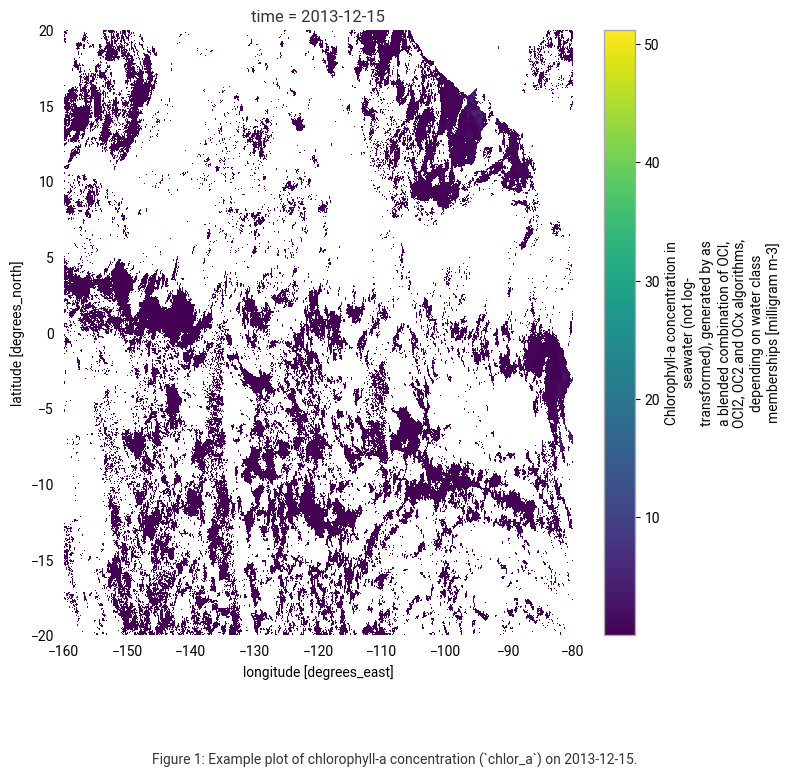

In [8]:
# Choose "chlor_a" or "analysed_sst" depending on selection from above
ds["chlor_a"].plot()

caption = (
    "Figure 1: Example plot of chlorophyll-a concentration (`chlor_a`) on 2013-12-15."
)
plt.figtext(0.5, -0.1, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.tight_layout()
plt.show()

The plot shows chlorophyll-a concentration data (not log-transformed) in milligrams per cubic meter (mg m⁻³) from the Ocean Colour dataset for December 15, 2013.<br> 
White areas indicate missing or masked data. The main reasons for these data gaps are cloud cover, sun glint, daily variability in atmospheric conditions, and satellite coverage. 

**To address these gaps, we will use monthly aggregated composites for subsequent spatial analysis.**

## Understanding Chlorophyll-a and Sea Surface Temperature during El Niño and La Niña events

In this section, we will study the **daily-temporal** and **monthly-spatical** dynamics of Chlorophyll-a and Sea Surface Temperature during the month December in an El Nino (2015) and a La Nina (1999) year compared to a "neutral" year (2013).

### Create a daily time series

In this first analysis, we will plot the daily data as time series, allowing us to observe the variations in `chlor_a` concentrations and `analysed_SST` for December across the years. <br> 

A time series analysis is essential for understanding temporal fluctuations and identifying trends that may be influenced by climatic events such as El Niño and La Niña. By examining daily variations, we can capture the timing and intensity of anomalies, as well as their persistence and recovery periods. Comparing these patterns across the specified years (1999, 2013, 2015) provides insight into how these climate events affect ocean conditions on a day-to-day basis.

To do that, we will first define a function to load and process our downloaded December data:

In [9]:
# Function to load and process December data
def load_december_data(base_path, var_name):
    data_dict = {}
    years = {"1999-12": "La Niña", "2013-12": "Neutral", "2015-12": "El Niño"}

    for year, phase in years.items():
        file_pattern = f"{base_path}/{year}/*.nc"
        files = glob.glob(file_pattern)

        if not files:
            print(f"No files found in {file_pattern}")
            continue

        ds = xr.open_mfdataset(files, combine="by_coords")
        ds = ds.sel(time=ds.time.dt.month == 12)

        # Reduce spatial dimensions (lat, lon) to a single value per time step using the mean
        ds_mean = ds[var_name].mean(dim=["lat", "lon"])

        data_dict[(int(year[: 4]), phase)] = ds_mean

    return data_dict

Now, we will load our daily data and create two time series plots using the function from above:

/var/folders/kx/ksg5wbrj1sq95rp2tz_72j6c0000gn/T/ipykernel_7850/264043643.py:40: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


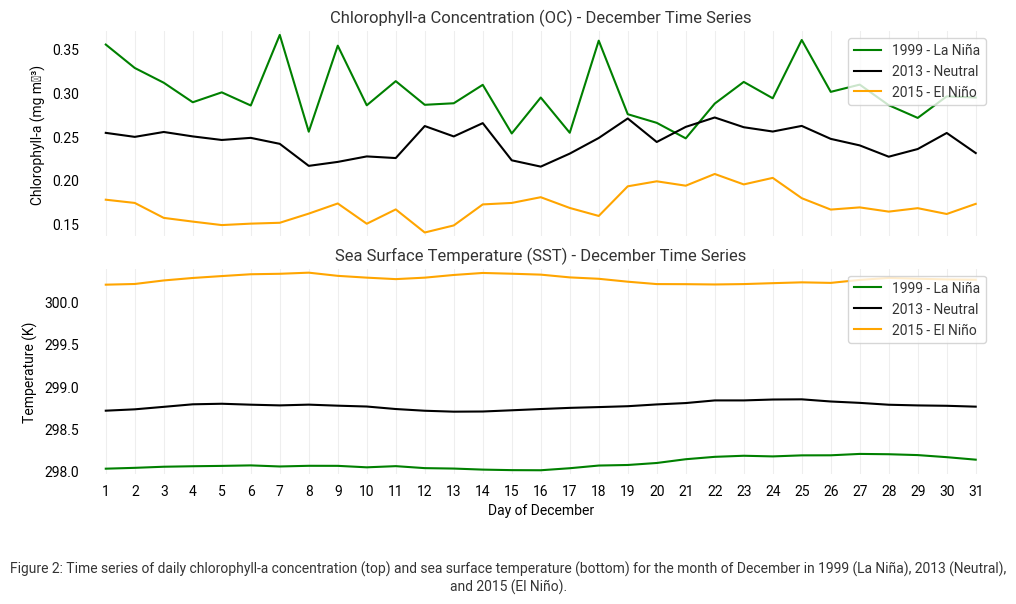

In [10]:
# Load OC (chlorophyll-a) and SST (sea surface temperature) data
oc_data = load_december_data("./data_cds_oc", "chlor_a")
sst_data = load_december_data("./data_cds_sst", "analysed_sst")

# Define colors:
oc_colors = {"1999": "green", "2013": "black", "2015": "orange"}
sst_colors = {"1999": "green", "2013": "black", "2015": "orange"}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot OC data (Chlorophyll-a)
for (year, phase), ds in oc_data.items():
    axes[0].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=oc_colors[str(year)])

# Plot SST data (Sea Surface Temperature)
for (year, phase), ds in sst_data.items():
    axes[1].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=sst_colors[str(year)])

# Set titles and labels
axes[0].set_title("Chlorophyll-a Concentration (OC) - December Time Series")
axes[1].set_title("Sea Surface Temperature (SST) - December Time Series")
axes[1].set_xlabel("Day of December")
axes[1].set_xticks(range(1, 32))

# Configure legends and y-axis labels
for ax in axes:
    ax.set_ylabel("Chlorophyll-a (mg m⁻³)" if ax == axes[0] else "Temperature (K)")
    ax.grid()
    ax.legend(loc="upper right")

# Add figure caption
caption = (
    "Figure 2: Time series of daily chlorophyll-a concentration (top) and sea surface temperature (bottom) "
    "for the month of December in 1999 (La Niña), 2013 (Neutral), and 2015 (El Niño)."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.20)
plt.show()

The two plots display the time series of **Chlorophyll-a Concentration (OC)** and **Sea Surface Temperature (SST)** for December in different years associated with La Niña (1999), Neutral (2013), and El Niño (2015) conditions in the equatorial Pacific area that we have selected.

1. **Chlorophyll-a Concentration (Top Plot)**
   - **La Niña (1999, Green)**: Higher and more variable chlorophyll-a concentrations indicate stronger upwelling and increased nutrient availability, promoting phytoplankton growth.
   - **Neutral (2013, Black)**: Moderate concentrations.
   - **El Niño (2015, Orange)**: Lower chlorophyll-a levels suggest suppressed upwelling, leading to reduced nutrient availability and less phytoplankton activity.

2. **Sea Surface Temperature (Bottom Plot)**
   - **La Niña (1999, Green)**: Cooler SSTs align with intensified upwelling, bringing colder, nutrient-rich waters to the surface.
   - **Neutral (2013, Black)**: Intermediate SSTs.
   - **El Niño (2015, Orange)**: Warmer SSTs, typical of El Niño conditions, where upwelling is weakened due to a deeper thermocline, reducing nutrient availability and biological productivity.

This analysis confirms the typical effects of **El Niño** (warmer SSTs, lower chlorophyll) and **La Niña** (cooler SSTs, higher chlorophyll) on oceanic conditions, illustrating their significant influence on marine ecosystems.

### Analyse spatial distribution of monthly averages

In this section, we will visualise and analyse the spatial distribution of Chlorophyll-a and Sea Surface Temperature during El Niño (2015) and La Niña (1999) events compared to a "neutral" year (2013). By comparing these events to a neutral year, we can better understand how anomalous climate phenomena affect the distribution of key ocean variables, which is crucial for ecosystem management, climate modeling, and assessing the impacts of climate variability.

A spatial assessment of chlorophyll-a and sea surface temperature is crucial for understanding how these variables vary across different regions of the ocean during El Niño and La Niña events. Spatial patterns reveal localised changes in ocean productivity and thermal structure that are not evident from temporal averages alone. This approach allows us to identify regions most affected by climate anomalies, such as shifts in upwelling zones and changes in nutrient availability.

#### Aggregate daily into monthly data

We want to aggregate the daily to monthly mean datasets for each December of 1999, 2013 and 2015 to continue with the analysis of the spatial distribution of `chlor_a` and `analysed_SST` variables.

The script provided here aggregates daily data into monthly means for December of 1999, 2013, and 2015. It saves the results in new NetCDF files for further spatial analysis.

The following steps are made to get the monthly data:
1. **Define Input/Output Paths**: Specifies where to find and save the data.
2. **Ensure Directories**: Creates output directories if they don't exist.
3. **Process Data**:  
   - Loops through specified months.  
   - Loads daily data using `xarray`.  
   - Computes monthly means.
4. **Save Results**: Saves the aggregated data in NetCDF format.

In [11]:
# Define input and output paths
input_dirs = {"oc": "./data_cds_oc", "sst": "./data_cds_sst"}
output_dirs = {
    "oc": "./data_cds_monthly/monthly_oc",
    "sst": "./data_cds_monthly/monthly_sst",
}
var_names = {"oc": "chlor_a", "sst": "analysed_sst"}

# Ensure output directories exist
for out_dir in output_dirs.values():
    os.makedirs(out_dir, exist_ok=True)


def process_monthly_means(base_path, output_path, var_name):
    """Processes daily NetCDF files, calculates monthly means, and saves as new files."""
    for folder in ["1999-12", "2013-12", "2015-12"]:
        folder_path = os.path.join(base_path, folder)

        files = sorted(
            [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]
        )

        if not files:
            print(f"No files found in {folder_path}, skipping...")
            continue

        # Open multiple NetCDF files as one dataset
        ds = xr.open_mfdataset(files, combine="by_coords")

        # Compute the monthly mean
        ds_monthly = ds[var_name].resample(time="ME").mean()

        # Save the output file
        year_month = folder  # Example: "1999-12"
        output_file = os.path.join(output_path, f"{var_name}_{year_month}.nc")
        ds_monthly.to_netcdf(output_file)

        print(f"Saved: {output_file}")


# Process OC and SST data
process_monthly_means(input_dirs["oc"], output_dirs["oc"], var_names["oc"])
process_monthly_means(input_dirs["sst"], output_dirs["sst"], var_names["sst"])

Saved: ./data_cds_monthly/monthly_oc/chlor_a_1999-12.nc
Saved: ./data_cds_monthly/monthly_oc/chlor_a_2013-12.nc
Saved: ./data_cds_monthly/monthly_oc/chlor_a_2015-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_1999-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_2013-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_2015-12.nc


#### Create monthly average maps

Visualizing **monthly average Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** helps to understand oceanographic conditions under different climate events like **La Niña (1999), Neutral (2013), and El Niño (2015)**. These maps provide insights into:
- Variations in **biological productivity** (by proxy of Chlorophyll-a).
- Variations in **ocean temperature** (SST).

We will create six monthly maps in one figure following these steps:
1. Load **December** data for each year.
2. Use **LogNorm** for Chlorophyll-a to account for the large dynamic range.
3. Use **consistent color scales** across years for easy comparison.
4. Arrange maps in a **3x2 grid**:
   - **Left column:** Chlorophyll-a
   - **Right column:** SST

/var/folders/kx/ksg5wbrj1sq95rp2tz_72j6c0000gn/T/ipykernel_7850/550744277.py:97: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


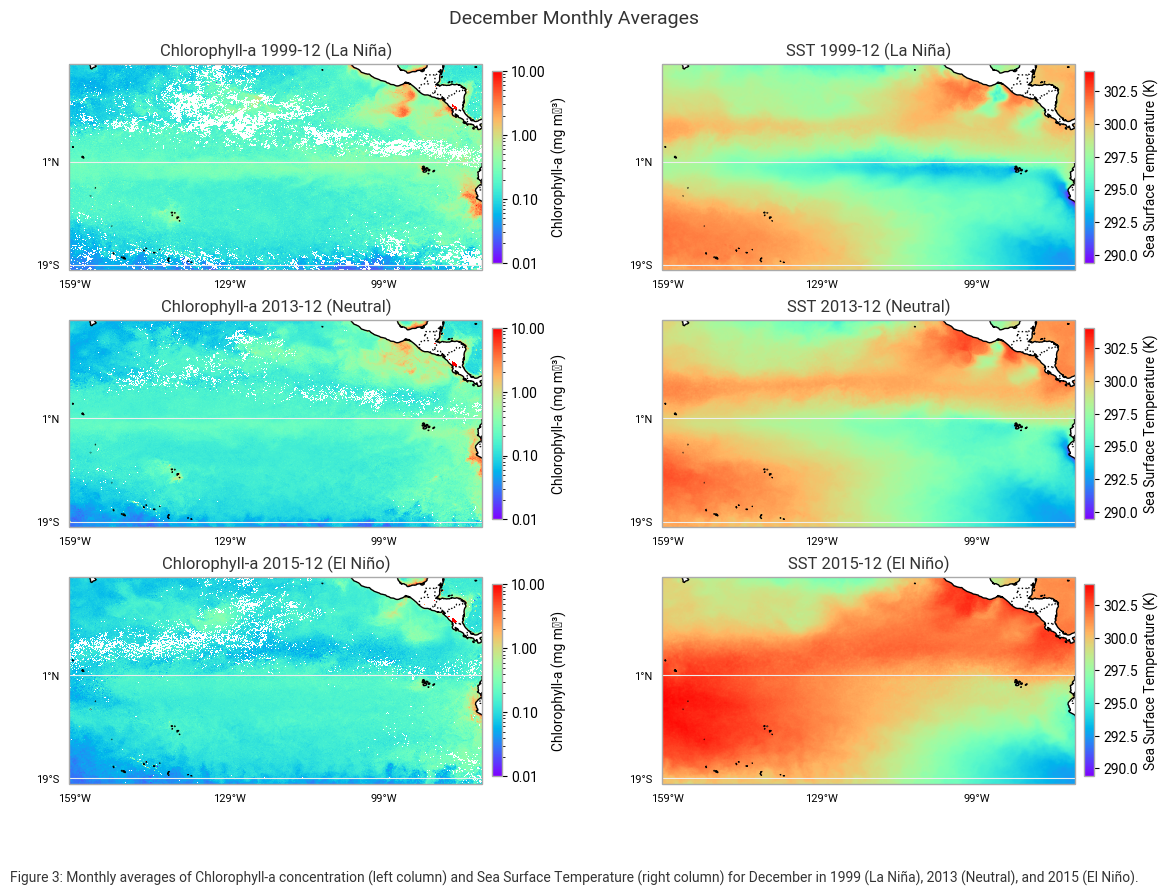

In [12]:
# Define paths to monthly data
base_dir = "./data_cds_monthly"
oc_files = [
    os.path.join(base_dir, "monthly_oc", f"chlor_a_{year}-12.nc")
    for year in [1999, 2013, 2015]
]
sst_files = [
    os.path.join(base_dir, "monthly_sst", f"analysed_sst_{year}-12.nc")
    for year in [1999, 2013, 2015]
]

# Open datasets
oc_datasets = [xr.open_dataset(f) for f in oc_files]
sst_datasets = [xr.open_dataset(f) for f in sst_files]

# Define figure and axes (3x2 grid)
fig, axes = plt.subplots(
    3, 2, figsize=(12, 9), subplot_kw={"projection": ccrs.PlateCarree()}
)
fig.suptitle("December Monthly Averages", fontsize=14)

# Function to plot data with automatic tick labeling based on dataset extent
def plot_map(ax, ds, var_name, title, cmap, norm=None):
    data = ds[var_name].squeeze()
    lat = data.lat if "lat" in data.coords else data.latitude
    lon = data.lon if "lon" in data.coords else data.longitude

    img = ax.pcolormesh(
        lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    # Get extent from data
    lon_min, lon_max = float(lon.min()), float(lon.max())
    lat_min, lat_max = float(lat.min()), float(lat.max())

    # Set ticks within data extent
    x_ticks = list(range(int(lon_min), int(lon_max) + 1, 30))
    y_ticks = list(range(int(lat_min), int(lat_max) + 1, 20))
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    return img

# Define labels for each year
labels = {1999: "La Niña", 2013: "Neutral", 2015: "El Niño"}

# Define colormaps
chlorophyll_cmap = "rainbow"
sst_cmap = "rainbow"

# Define LogNorm for chlor_a
chlor_norm = LogNorm(vmin=0.01, vmax=10)

# Plot Chlorophyll-a (left column)
for i, (ds, year) in enumerate(zip(oc_datasets, [1999, 2013, 2015])):
    title = f"Chlorophyll-a {year}-12 ({labels[year]})"
    img = plot_map(
        axes[i, 0], ds, "chlor_a", title, chlorophyll_cmap, norm=chlor_norm
    )
    cbar = fig.colorbar(
        img,
        ax=axes[i, 0],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Chlorophyll-a (mg m⁻³)",
    )
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

# Determine global min/max for SST
sst_min = min(ds["analysed_sst"].min().item() for ds in sst_datasets)
sst_max = max(ds["analysed_sst"].max().item() for ds in sst_datasets)
sst_norm = Normalize(vmin=sst_min, vmax=sst_max)

# Plot SST (right column)
for i, (ds, year) in enumerate(zip(sst_datasets, [1999, 2013, 2015])):
    title = f"SST {year}-12 ({labels[year]})"
    img_sst = plot_map(
        axes[i, 1], ds, "analysed_sst", title, sst_cmap, norm=sst_norm
    )
    fig.colorbar(
        img_sst,
        ax=axes[i, 1],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Sea Surface Temperature (K)",
    )

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.12)  # Reserve space for caption

# Add figure caption (below the plots)
caption = (
    "Figure 3: Monthly averages of Chlorophyll-a concentration (left column) and Sea Surface Temperature (right column) for December "
    "in 1999 (La Niña), 2013 (Neutral), and 2015 (El Niño)."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Show final figure
plt.show()


In December 1999, during **La Niña**, Chlorophyll-a concentrations were high along the equator and near coastal upwelling zones. The sea surface temperature (SST) was cooler, particularly along the equator, due to the intensified upwelling of deep, cold water.

In December 2013, under **neutral** conditions, Chlorophyll-a levels were intermediate and more evenly distributed across the region. The SST was moderate ocean circulation patterns remained relatively stable.

In December 2015, during **El Niño**, Chlorophyll-a concentrations were significantly reduced in the equatorial Pacific. At the same time, SST was much warmer, with warm water spreading across the central and eastern Pacific, a hallmark of El Niño conditions.

### Create anomaly maps

In this section we will create anomaly maps. Anomaly maps are useful for identifying deviations from normal conditions, helping to visualize the impact of climate events like El Niño and La Niña. By comparing **Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** for different years against a neutral reference year, we can assess how ocean conditions deviate during extreme climate events.

We will create four anomaly maps using these steps:
1. Select a **neutral year** (2013) as the baseline.
2. Compute anomalies by subtracting the neutral year's values from those of La Niña (1999) and El Niño (2015).
3. Visualize differences using a diverging colormap (e.g., **red for positive, blue for negative anomalies**).

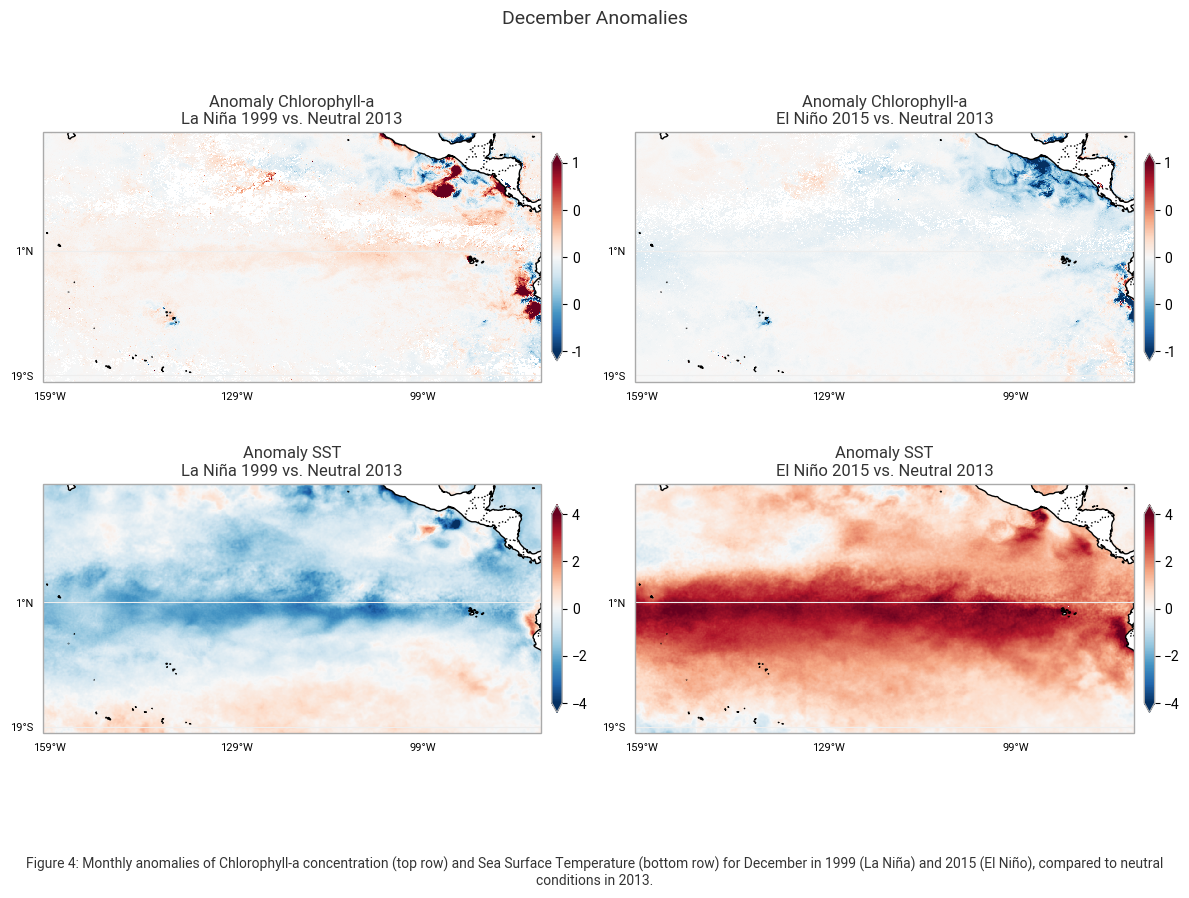

In [13]:
# Neutral data is from 2013
neutral_oc = oc_datasets[1]["chlor_a"].squeeze()
neutral_sst = sst_datasets[1]["analysed_sst"].squeeze()

# Function to calculate anomalies
def calculate_anomalies(data, neutral_data):
    return data - neutral_data

# Function to plot map with geographic ticks based on dataset extent
def plot_map(ax, data, title, cmap, norm=None):
    lat = data.lat if "lat" in data.coords else data.latitude
    lon = data.lon if "lon" in data.coords else data.longitude

    img = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # Determine tick positions based on dataset extent
    lon_min, lon_max = float(lon.min()), float(lon.max())
    lat_min, lat_max = float(lat.min()), float(lat.max())

    x_ticks = list(range(int(lon_min), int(lon_max) + 1, 30))
    y_ticks = list(range(int(lat_min), int(lat_max) + 1, 20))
    ax.set_xticks(x_ticks, crs=ccrs.PlateCarree())
    ax.set_yticks(y_ticks, crs=ccrs.PlateCarree())
    ax.tick_params(labelsize=8)
    ax.xaxis.set_major_formatter(LONGITUDE_FORMATTER)
    ax.yaxis.set_major_formatter(LATITUDE_FORMATTER)

    return img

# Create a 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("December Anomalies", fontsize=14)

# Define colormaps and normalization
chlorophyll_cmap = "RdBu_r"
sst_cmap = "RdBu_r"
chlor_norm = Normalize(vmin=-1, vmax=1)
sst_norm = Normalize(vmin=-4, vmax=4)

# Chlorophyll-a anomaly: 1999 vs 2013
oc_anomaly_1999 = calculate_anomalies(oc_datasets[0]["chlor_a"].squeeze(), neutral_oc)
img_oc_1999 = plot_map(
    axes[0, 0], oc_anomaly_1999, "Anomaly Chlorophyll-a\nLa Niña 1999 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_1999 = fig.colorbar(
    img_oc_1999, ax=axes[0, 0], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)
cbar_oc_1999.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

# SST anomaly: 1999 vs 2013
sst_anomaly_1999 = calculate_anomalies(sst_datasets[0]["analysed_sst"].squeeze(), neutral_sst)
img_sst_1999 = plot_map(
    axes[1, 0], sst_anomaly_1999, "Anomaly SST\nLa Niña 1999 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
fig.colorbar(
    img_sst_1999, ax=axes[1, 0], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)

# Chlorophyll-a anomaly: 2015 vs 2013
oc_anomaly_2015 = calculate_anomalies(oc_datasets[2]["chlor_a"].squeeze(), neutral_oc)
img_oc_2015 = plot_map(
    axes[0, 1], oc_anomaly_2015, "Anomaly Chlorophyll-a\nEl Niño 2015 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_2015 = fig.colorbar(
    img_oc_2015, ax=axes[0, 1], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)
cbar_oc_2015.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{int(y)}'))

# SST anomaly: 2015 vs 2013
sst_anomaly_2015 = calculate_anomalies(sst_datasets[2]["analysed_sst"].squeeze(), neutral_sst)
img_sst_2015 = plot_map(
    axes[1, 1], sst_anomaly_2015, "Anomaly SST\nEl Niño 2015 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
fig.colorbar(
    img_sst_2015, ax=axes[1, 1], orientation="vertical",
    fraction=0.02, pad=0.02, extend="both"
)

# Add figure caption
caption = (
    "Figure 4: Monthly anomalies of Chlorophyll-a concentration (top row) and Sea Surface Temperature (bottom row) for December "
    "in 1999 (La Niña) and 2015 (El Niño), compared to neutral conditions in 2013."
)
plt.figtext(0.5, 0.01, caption, wrap=True, horizontalalignment='center', fontsize=10)

# Layout adjustments
plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.10)
plt.show()


These maps highlights the anomalies in **Chlorophyll-a concentration** (mg m-3) and **Sea Surface Temperature (SST)** (K) for December, comparing the conditions during La Niña (1999) and El Niño (2015) to the neutral year of 2013. The left column represents deviations observed during La Niña, while the right column shows anomalies associated with El Niño.

- The **Chlorophyll-a anomaly maps** in the top row reveal distinct differences in biological productivity. During **La Niña in 1999**, positive anomalies (red areas) indicate increased Chlorophyll-a concentrations, particularly along the equatorial Pacific and coastal upwelling regions. This increase is due to stronger trade winds that enhance upwelling, bringing nutrient-rich waters to the surface and supporting higher phytoplankton growth. In contrast, during **El Niño in 2015**, negative anomalies (blue areas) dominate, showing a decline in Chlorophyll-a concentrations. This reduction results from weakened upwelling and decreased nutrient availability, leading to lower biological productivity in the eastern Pacific.

- The **SST anomaly maps** in the bottom row highlight the contrasting temperature patterns associated with La Niña and El Niño. In **La Niña (1999), negative SST anomalies** (blue areas) indicate cooler-than-average sea surface temperatures, particularly in the central and eastern Pacific. These cooler temperatures are a direct result of enhanced upwelling, which brings cold, deep ocean water to the surface. In contrast, **El Niño (2015) is characterized by strong positive SST anomalies** (red areas), with temperature increases exceeding **+4°C** across the central and eastern Pacific. This warming disrupts normal oceanic circulation and weakens the upwelling process, leading to significant climate and ecosystem impacts.

These anomaly maps clearly illustrate the **opposing effects of La Niña and El Niño** on ocean temperatures and marine productivity. La Niña promotes stronger upwelling, cooler temperatures, and increased Chlorophyll-a concentrations, while El Niño leads to significant ocean warming

## Take home messages 📌

In this notebook, we provided use cases based on the Ocean Colour (variable `chlor_a`) and Sea Surface Temperature (variable `analysed_sst`) datasets to illustrate how these CDS datasets can be used to study, analyze, and visualize the impacts of El Niño and La Niña events. 

- The datasets showed variations in chlorophyll-a and sea surface temperature patterns over time, with significant changes associated with major climate phenomena. 
- By comparing these patterns during El Niño and La Niña years, we can explore the relationships between these events and marine ecosystem dynamics, as well as global climate patterns
- Comparisons with other datasets can help further investigate the trends and anomalies caused by these climate events, providing insight into the broader impacts on ocean health, weather systems, and the global climate. For example, analyzing **[sea level anomaly](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-level-global?tab=overview)** and **[zonal and meridional wind components](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview)** alongside ocean colour and sea surface temperature can offer a more complete picture of the physical processes driving **El Niño** and **La Niña**.